# Predictive Analysis Solar Pannel Performance From Capacity

this analysis has goals to help company to achieve higher efficiency levels and reduce uncertainty in solar power production. And this analysis will supporting sustainability goals and reducing the dependenceies on fossil energy sorces. 

The dataset used in this predictive modeling consists of 3 datasets, namely the main dataset (consisting of timestamp and %Baseline), solar irradiance dataset (primary key timestamp), and weather dataset (primary key timestamp). The data source can be accessed at [the following link](https://www.kaggle.com/competitions/preliminary-round-dac-prs-2024/data)


## Introduction
- Introduction of importance of renewable energy while massive use of electricity and energy in this current decade
- Fixed Cost of Renewable energy is relative high, so people has tendencies to use traditional or fossil energy sources
- To reach more speed on break even poin, the optimilization of solar power production must to achieve. Installing a solar system can be a big investment, so most homeowners are always looking for ways to maximize their ROI by making their installation as efficient as possible.
- The importance tools that will help is Machine Learning that want to learning based on historical solar power optimalization production, help by data of weather and solar irradiance, also time series method. 

## Theoritical Framework

[Factors that effect performance of solar system](https://www.hoymiles.com/resources/blog/7-factors-that-affect-the-performance-of-your-solar-system/) 
- Enviromental Factors 
    - Irradiance (radiasi), amount of sunlight that hits solar panels at any given time -> positive correlation 
    - Temperature, higher temperature lower the output of solar panels (based on scientifict, when solar panel heats up, voltage of semiconducting material in the panel drops, thats make reduce pannels output). 
        peak efficiency betwee 15 - 35 degree celcius 
    The both seems counterintutive, but the solution suggestion as below 
        - give the gap between panels and roof so the air can easily circulate 
        - using microinvertes, to improce overall efficiency and reliabilty of solar system, the microinvertes will installed at underneath of the pannel that means ther're always in shade. 
        - using light colored roofing that reflect sunlight aroung panel 
- Equipment 
    - Solar penel degradations (overall, can expect panenls to degrade at rate of 8-14% during first 25 years after installed.)
    - solar panel orientation and tilt 
        the keys are calculating azimuth angle (compass direction from which the sun is hinning, placing pannels at tilt that keeps perpendicualr to the sun)
        - if on north equator, pannels shoud be facing south
        ![Pannel Orientation Suggestion](equipment_orientation.jpg)
    - shading and soliling (if can, dont shading lah, shade of thing from sun, dirt, or dust). Solution about temperature is using microinverter
    - Inverter Efficiency 
        - conversion efficiency
        - MPPT efficiency

## Data Understanding 
Heres are data that provided
- %Baseline : percentage of energy generated in one hour based on the energy storage capacity (Respons Variables)
- Timestamp (year, month, date, and hour)

### Solar_Irradiance
- DHI (Diffuse Horizontal Irradiance): Quantity of solar radiation received pwe unit area by a horizontal surface from all directions except the sun which has been scattered by molecules and particles in the atmosphere (Watt per Square Metre).
- DNI (Direct Normal Irradiance): Quantity of solar radiation received per unit area by surface amintained perpendicular to rays that come in straight line from sun current position in sky. 
- GHI (Global Horizontal Irradiance): Combination of DHI and DNI that follow this bellow formula: 
    GHI = DHI + DNI * Cos(θz) | θz stand for solar zenith angle. 
- Clearsky DHI: DHI radiation under clear sky condition 
- Clearsky DNI: DNI radiation under clear sky condition
- Clearsky GHI: GHI radiation under clear sky conditions. (Watt per square metre)
- Cloud Type: Classification of cloud types at the time of measurement: Clear
- Dew Point (titik embun): The temperature at which the air becomes saturated with moisture and water vapor begins to condense. (Celcius)
- Solar Zenith Angle: The angle between the sun’s rays and the vertical direction other than the solar elevation angle. (Degree)
- Surface Albedo : Index of shortwave radiation reflected from the ground or surface.
- Wind Speed: Wind speed at the time of measurement. (Metre per second)
- Relative Humidity: The amount of moisture in the air compared to what the air can hold at its current temperature. (Percentage)
- Temperature: Air temperature at the time of measurement. (Celsius)
- Pressure: Atmospheric pressure at the time of measurement. (Millibar)

### Weather
- maxtempC: Maximum temperature point of a region during a specific period. (Celsius)
- mintempC: Minimum temperature point of a region during a specific period. (Celsius)
- totalSnow_cm: Total accumulated snow height. (Centimetres)
- sunHour: Estimated total hours of sunlight.
- uvIndex: UV light index generated by the sun.
- moon_illumination: Moon illumination percentage (percentage of the moon's surface exposed to sunlight).
- moonrise: Moonrise time.
- moonset: Moonset time.
- sunrise: Sunrise time. 
- DewPointC: The temperature at which the air gets saturated with moisture and water vapor starts to condense. (Celsius)
- FeelsLikeC: Perceived temperature by considering factors such as air temperature
- HeatIndexC: The perceived heat index that is hotter than the actual air temperature due to the humidity factor. (Celsius)
- WindChillC: The perceived wind chill index that is colder than the actual air temperature due to wind factors. (Celsius)
- WindGustKmph: Maximum wind gust speed. (Kilometre per hour)
- cloudcover: Percentage of cloud coverage.
- humidity: Percentage of air humidity. 
- precipMM: Total precipitation (in one square metre of flat area with collected rainwater to a certain height in millimetre)
- pressure: Air pressure. (Millibar)
- tempC: Air temperature at the time of measurement. (Celsius)
- visibility: Range of vision. (Kilometre)
- winddirDegree: Wind direction. (Degree)
- windspeedKmph: Average wind speed. (Kilometre per hour)

## Library Loading

In [336]:
STATE = 123
import pandas as pd # dataframe handling
import matplotlib.pyplot as plt # visualisasi
import seaborn as sns # also visualization, more style
import numpy as np # math handling
from sklearn.preprocessing import  OneHotEncoder # buat data preprocessing one hot encoding 
from sklearn.decomposition import PCA # handling Principle Component Analysis
from sklearn.model_selection import (train_test_split, KFold, cross_val_score as cvs,
    cross_val_predict as cvp,
) # cross val, scoring, KFold
from sklearn.preprocessing import StandardScaler # standardization
from sklearn import ensemble, linear_model # for ensemble learning, ridge as linear
import xgboost as xgb # xgb
import lightgbm as lgbm # Light Gradient Boosting Machine
import catboost as cb # Cat boost
from sklearn.metrics import mean_squared_error as mse # handling evaluation metric (bridging to RMSE)
import time # handling time
from sklearn.preprocessing import PolynomialFeatures # making polynomials
import optuna # hypertunning
from sklearn.svm import NuSVR # NUSVR model

## Data Wrangling

### Sample Submission

In [337]:
# read submission format 
sample_submission = pd.read_csv(r"dataset\sample_submission.csv")

In [338]:
# count submission
len(sample_submission)

1077

### Train

In [339]:
# read train data
train = pd.read_csv(r"dataset\train.csv")

In [340]:
# Train Data top 5 by index
train.head()

,Timestamp,% Baseline
0,"Jan 1, 2014 7am",0.0079
1,"Jan 1, 2014 8am",0.1019
2,"Jan 1, 2014 9am",0.3932
3,"Jan 1, 2014 10am",0.5447
4,"Jan 1, 2014 11am",0.5485


In [341]:
# Overview data that will be train
banyakTrain = len(train)
firstDateTrain = train.iloc[0, 0]
lastDateTrain = train.iloc[-1, 0]
print(f"Banyak data pada train {banyakTrain}, \nTanggal pada data pertama {firstDateTrain}\nTanggal pada data terakhir {lastDateTrain}")

Banyak data pada train 18942, 
Tanggal pada data pertama Jan 1, 2014 7am
Tanggal pada data terakhir Sep 30, 2017 6pm


In [342]:
train.dtypes # type of each columns of train

Timestamp      object
% Baseline    float64
dtype: object

In [343]:
# So that can be Integrate Later 
train["Timestamp"] = pd.to_datetime(train["Timestamp"]) # after some trials it can be without format 

### Test

In [ ]:
# read test set that will be submit 
test = pd.read_csv(r"dataset/test.csv")

In [ ]:
# overview of testing set 
banyakTest = len(test)
firstDateTest = test.iloc[0, 0]
lastDateTest = test.iloc[-1, 0]
print(f"Banyak data pada train {banyakTest}, \nTanggal pada data pertama {firstDateTest}\nTanggal pada data terakhir {lastDateTest}")

Banyak data pada train 1077, 
Tanggal pada data pertama Oct 1, 2017 6am
Tanggal pada data terakhir Dec 31, 2017 4pm


Here, we can see data that will test is data of forecasting of train data, not data based on random date. 

In [ ]:
# So that can be Integrate Later 
test["Timestamp"] = pd.to_datetime(test["Timestamp"]) # after some trials and checks it can be without format 

### Weather

In [ ]:
# read weather data 
weather = pd.read_csv(r"dataset\Weather.csv")

In [ ]:
# top 5 weather data by index
weather.head()

,date_time,maxtempC,mintempC,totalSnow_cm,sunHour,uvIndex,moon_illumination,moonrise,moonset,sunrise,...,WindChillC,WindGustKmph,cloudcover,humidity,precipMM,pressure,tempC,visibility,winddirDegree,windspeedKmph
0,1/1/2014 0:00,-3,-6,0.0,8.7,2,1,6:58 AM,5:05 PM,7:12 AM,...,-11,28,3,58,0.0,1022,-4,10,273,20
1,1/1/2014 1:00,-3,-6,0.0,8.7,2,1,6:58 AM,5:05 PM,7:12 AM,...,-12,31,4,58,0.0,1023,-5,10,274,22
2,1/1/2014 2:00,-3,-6,0.0,8.7,2,1,6:58 AM,5:05 PM,7:12 AM,...,-12,34,5,58,0.0,1024,-5,10,276,25
3,1/1/2014 3:00,-3,-6,0.0,8.7,2,1,6:58 AM,5:05 PM,7:12 AM,...,-13,36,6,58,0.0,1024,-5,10,278,27
4,1/1/2014 4:00,-3,-6,0.0,8.7,2,1,6:58 AM,5:05 PM,7:12 AM,...,-13,32,9,57,0.0,1025,-6,10,271,23


In [ ]:
# check types of each columns of weather data
weather.dtypes

date_time             object
maxtempC               int64
mintempC               int64
totalSnow_cm         float64
sunHour              float64
uvIndex                int64
moon_illumination      int64
moonrise              object
moonset               object
sunrise               object
sunset                object
DewPointC              int64
FeelsLikeC             int64
HeatIndexC             int64
WindChillC             int64
WindGustKmph           int64
cloudcover             int64
humidity               int64
precipMM             float64
pressure               int64
tempC                  int64
visibility             int64
winddirDegree          int64
windspeedKmph          int64
dtype: object

In [ ]:
# change date_time types to datetime without format, because it can learn the format
weather["date_time"] = pd.to_datetime(weather["date_time"])

### Solar Irradiance

In [ ]:
# read data solar irradiance each year (2014-2017)
si_2014 = pd.read_csv(r"dataset\solar-irradiance\Solar_Irradiance_2014.csv")
si_2015 = pd.read_csv(r"dataset\solar-irradiance\Solar_Irradiance_2015.csv")
si_2016 = pd.read_csv(r"dataset\solar-irradiance\Solar_Irradiance_2016.csv")
si_2017 = pd.read_csv(r"dataset\solar-irradiance\Solar_Irradiance_2017.csv")

In [ ]:
# check number data of each year
m = 2014
for i in [si_2014, si_2015, si_2016, si_2017]:
    print(f"Number data and columns Solar Irradiance {m}: {len(i)}, {len(i.columns)}")
    m += 1

Number data and columns Solar Irradiance 2014: 8760, 19
Number data and columns Solar Irradiance 2015: 8760, 19
Number data and columns Solar Irradiance 2016: 8784, 19
Number data and columns Solar Irradiance 2017: 8760, 19


we will merge data, as the data same between columns as notes 2016 has more on data, because it is cabisat year (so plus 1 day or 24 hour) then surplus for 24 data. 

In [ ]:
# merge into one data 
solar_irradiance = pd.concat([si_2014, si_2015, si_2016, si_2017])

In [ ]:
# Number SI total data
len(solar_irradiance)

35064

In [ ]:
# top 5 data solar irradiance by index
solar_irradiance.head()

,Year,Month,Day,Hour,Minute,DHI,DNI,GHI,Clearsky DHI,Clearsky DNI,Clearsky GHI,Cloud Type,Dew Point,Solar Zenith Angle,Surface Albedo,Wind Speed,Relative Humidity,Temperature,Pressure
0,2014,1,1,0,0,0.0,0.0,0.0,0.0,0.0,0.0,Probably Clear,-6,124.02,0.12,3.5,78.43,-3,1010
1,2014,1,1,1,0,0.0,0.0,0.0,0.0,0.0,0.0,Probably Clear,-5,135.09,0.12,3.8,81.74,-3,1010
2,2014,1,1,2,0,0.0,0.0,0.0,0.0,0.0,0.0,Probably Clear,-5,145.77,0.12,4.2,81.25,-3,1010
3,2014,1,1,3,0,0.0,0.0,0.0,0.0,0.0,0.0,Probably Clear,-6,155.07,0.12,4.5,74.14,-3,1010
4,2014,1,1,4,0,0.0,0.0,0.0,0.0,0.0,0.0,Probably Clear,-8,160.55,0.12,4.6,72.80,-4,1010


In [ ]:
# check data type of each columns
solar_irradiance.dtypes

Year                    int64
Month                   int64
Day                     int64
Hour                    int64
Minute                  int64
DHI                   float64
DNI                   float64
GHI                   float64
Clearsky DHI          float64
Clearsky DNI          float64
Clearsky GHI          float64
Cloud Type             object
Dew Point               int64
Solar Zenith Angle    float64
Surface Albedo        float64
Wind Speed            float64
Relative Humidity     float64
Temperature             int64
Pressure                int64
dtype: object

In [ ]:
# check wheather data that has minutes more than 0 
solar_irradiance[solar_irradiance["Minute"]>0]
## it is safe

,Year,Month,Day,Hour,Minute,DHI,DNI,GHI,Clearsky DHI,Clearsky DNI,Clearsky GHI,Cloud Type,Dew Point,Solar Zenith Angle,Surface Albedo,Wind Speed,Relative Humidity,Temperature,Pressure


In [ ]:
# new column call as next_datetime to integrate some features in order to concatenate with other data in next chapter
solar_irradiance["next_datetime"] = solar_irradiance["Year"].astype(str) + "/" + solar_irradiance["Month"].astype(str) + "/"+ solar_irradiance["Day"].astype(str) + "/"+ solar_irradiance["Hour"].astype(str) + "/"+ solar_irradiance["Minute"].astype(str)

In [ ]:
# check next_datetime column
solar_irradiance["next_datetime"][-10:]

8750    2017/12/31/14/0
8751    2017/12/31/15/0
8752    2017/12/31/16/0
8753    2017/12/31/17/0
8754    2017/12/31/18/0
8755    2017/12/31/19/0
8756    2017/12/31/20/0
8757    2017/12/31/21/0
8758    2017/12/31/22/0
8759    2017/12/31/23/0
Name: next_datetime, dtype: object

In [ ]:
# convert next_datetime to datetime with the format
solar_irradiance["date_time"] = pd.to_datetime(solar_irradiance["next_datetime"], format="%Y/%m/%d/%H/%M")

In [ ]:
# drop some unnecassary or bridging columns
solar_irradiance = solar_irradiance.drop(["next_datetime", "Minute"], axis=1)

### Final Data (Integrate 2 Data)

After do trials and checking in order to better interpolate, it would be integrate data weather and train, testing. Meanwhile Solar Irradiance would be treatment as missing value first then integrate with other data. 

#### Train

In [ ]:
# Show amount of data from train 
len(train)

18942

In [ ]:
# merge with weather 
train = train.merge(weather, left_on='Timestamp', right_on='date_time', how='inner')
# drop double columns 
train = train.drop(["date_time"], axis=1)

In [ ]:
# Recheck again
len(train)

18942

#### Test

In [ ]:
# Show amount of data from test 
len(test)

1077

In [ ]:
# merge with weather 
test = test.merge(weather, left_on='Timestamp', right_on='date_time', how='inner')
# drop double columns 
test = test.drop(["date_time"], axis=1)

In [ ]:
# check again
len(test)

1077

## Exploratory Data Analysis

### Acessing Data

#### Train

In [ ]:
# checking data type of each columns
train.dtypes

Timestamp            datetime64[ns]
% Baseline                  float64
maxtempC                      int64
mintempC                      int64
totalSnow_cm                float64
sunHour                     float64
uvIndex                       int64
moon_illumination             int64
moonrise                     object
moonset                      object
sunrise                      object
sunset                       object
DewPointC                     int64
FeelsLikeC                    int64
HeatIndexC                    int64
WindChillC                    int64
WindGustKmph                  int64
cloudcover                    int64
humidity                      int64
precipMM                    float64
pressure                      int64
tempC                         int64
visibility                    int64
winddirDegree                 int64
windspeedKmph                 int64
dtype: object

In [ ]:
# descriptive analysis of numerical columns 
train.describe()

,% Baseline,maxtempC,mintempC,totalSnow_cm,sunHour,uvIndex,moon_illumination,DewPointC,FeelsLikeC,HeatIndexC,WindChillC,WindGustKmph,cloudcover,humidity,precipMM,pressure,tempC,visibility,winddirDegree,windspeedKmph
count,18942.000000,18942.000000,18942.000000,18942.000000,18942.000000,18942.000000,18942.000000,18942.000000,18942.000000,18942.000000,18942.000000,18942.000000,18942.000000,18942.000000,18942.000000,18942.000000,18942.000000,18942.000000,18942.000000,18942.000000
mean,0.242342,15.267976,8.814539,0.107745,10.669069,3.850966,49.917538,7.765759,11.429522,13.402597,11.127125,24.207317,39.700243,72.296378,0.104593,1016.140481,12.964154,9.290149,191.962676,15.826417
std,0.256525,9.434761,8.451514,0.829356,3.343624,1.743948,28.898236,9.079135,11.601362,9.648798,11.223448,12.266894,34.311097,14.822395,0.399039,7.702397,9.131196,1.836104,92.236925,7.937315
min,0.000000,-12.000000,-20.000000,0.000000,3.400000,1.000000,0.000000,-22.000000,-32.000000,-20.000000,-32.000000,0.000000,0.000000,19.000000,0.000000,979.000000,-20.000000,0.000000,0.000000,0.000000
25%,0.031800,8.000000,3.000000,0.000000,8.700000,2.000000,25.000000,2.000000,3.000000,6.000000,3.000000,15.000000,9.000000,61.000000,0.000000,1011.000000,6.000000,10.000000,125.000000,10.000000
50%,0.134700,16.000000,10.000000,0.000000,11.600000,4.000000,50.000000,9.000000,13.000000,14.000000,13.000000,23.000000,29.000000,73.000000,0.000000,1016.000000,14.000000,10.000000,205.000000,15.000000
75%,0.407700,24.000000,16.000000,0.000000,13.700000,5.000000,75.000000,15.000000,21.000000,21.000000,21.000000,31.000000,68.000000,84.000000,0.000000,1021.000000,21.000000,10.000000,264.000000,20.000000
max,1.016900,32.000000,23.000000,22.200000,14.500000,7.000000,100.000000,25.000000,36.000000,36.000000,32.000000,98.000000,100.000000,100.000000,8.000000,1045.000000,32.000000,10.000000,360.000000,70.000000


In [ ]:
# check whether data that baseline more than 1 
train[train["% Baseline"]>1]

,Timestamp,% Baseline,maxtempC,mintempC,totalSnow_cm,sunHour,uvIndex,moon_illumination,moonrise,moonset,...,WindChillC,WindGustKmph,cloudcover,humidity,precipMM,pressure,tempC,visibility,winddirDegree,windspeedKmph
895,2014-03-24 12:00:00,1.0013,5,1,0.0,10.5,2,45,1:13 AM,11:16 AM,...,2,22,70,64,0.0,1018,5,10,124,17
1251,2014-04-16 12:00:00,1.0169,5,-1,9.4,13.2,1,89,8:07 PM,5:46 AM,...,-2,25,0,54,0.0,1028,3,10,340,22
1379,2014-04-24 12:00:00,1.0080,11,4,0.0,13.9,3,35,2:03 AM,1:42 PM,...,7,45,11,43,0.0,1006,11,10,333,33


- % Baseline: There are some value that out of 1, maybe it is seems not make sense because outside of range (0-1), but if we look at number of data only 3 and it maybe can outside of energy capacity. 

#### Test

In [ ]:
# descriptive analysis of numerical columns 
test.describe()

,% Baseline,maxtempC,mintempC,totalSnow_cm,sunHour,uvIndex,moon_illumination,DewPointC,FeelsLikeC,HeatIndexC,WindChillC,WindGustKmph,cloudcover,humidity,precipMM,pressure,tempC,visibility,winddirDegree,windspeedKmph
count,0.0,1077.00000,1077.000000,1077.000000,1077.000000,1077.000000,1077.000000,1077.000000,1077.000000,1077.000000,1077.000000,1077.000000,1077.000000,1077.000000,1077.000000,1077.000000,1077.000000,1077.000000,1077.000000,1077.000000
mean,NaN,11.17363,5.444754,0.153668,7.657939,3.224698,52.207057,2.819870,6.917363,9.388115,6.824513,22.644383,39.509749,65.741876,0.096843,1018.828227,9.176416,9.428041,204.149489,15.948004
std,NaN,8.67690,7.898518,0.799406,2.445158,1.433022,28.967178,9.285689,10.876446,8.951427,10.730296,10.772349,35.594697,14.681572,0.406441,8.787412,8.624255,1.701648,91.454007,7.639842
min,NaN,-11.00000,-14.000000,0.000000,3.400000,1.000000,0.000000,-19.000000,-23.000000,-13.000000,-23.000000,2.000000,0.000000,35.000000,0.000000,987.000000,-13.000000,0.000000,0.000000,1.000000
25%,NaN,6.00000,0.000000,0.000000,5.500000,2.000000,27.000000,-3.000000,0.000000,3.000000,0.000000,14.000000,6.000000,55.000000,0.000000,1014.000000,3.000000,10.000000,143.000000,10.000000
50%,NaN,12.00000,4.000000,0.000000,8.700000,3.000000,54.000000,3.000000,6.000000,9.000000,6.000000,22.000000,29.000000,64.000000,0.000000,1019.000000,9.000000,10.000000,218.000000,15.000000
75%,NaN,18.00000,12.000000,0.000000,8.700000,4.000000,78.000000,10.000000,17.000000,17.000000,17.000000,30.000000,72.000000,77.000000,0.000000,1025.000000,17.000000,10.000000,277.000000,21.000000
max,NaN,25.00000,21.000000,7.500000,11.600000,6.000000,100.000000,21.000000,26.000000,26.000000,25.000000,53.000000,100.000000,98.000000,4.800000,1038.000000,25.000000,10.000000,359.000000,38.000000


### Handling Missing Value

In [ ]:
# Checking Missing Value of train set
train.isnull().sum()

Timestamp            0
% Baseline           0
maxtempC             0
mintempC             0
totalSnow_cm         0
sunHour              0
uvIndex              0
moon_illumination    0
moonrise             0
moonset              0
sunrise              0
sunset               0
DewPointC            0
FeelsLikeC           0
HeatIndexC           0
WindChillC           0
WindGustKmph         0
cloudcover           0
humidity             0
precipMM             0
pressure             0
tempC                0
visibility           0
winddirDegree        0
windspeedKmph        0
dtype: int64

In [ ]:
# Checking Missing Value of testing set
test.isnull().sum()

Timestamp               0
% Baseline           1077
maxtempC                0
mintempC                0
totalSnow_cm            0
sunHour                 0
uvIndex                 0
moon_illumination       0
moonrise                0
moonset                 0
sunrise                 0
sunset                  0
DewPointC               0
FeelsLikeC              0
HeatIndexC              0
WindChillC              0
WindGustKmph            0
cloudcover              0
humidity                0
precipMM                0
pressure                0
tempC                   0
visibility              0
winddirDegree           0
windspeedKmph           0
dtype: int64

In [ ]:
# Checking Missing Value of solar irradiance set
solar_irradiance.isnull().sum()

Year                     0
Month                    0
Day                      0
Hour                     0
DHI                   2777
DNI                   2777
GHI                   2777
Clearsky DHI          2777
Clearsky DNI          2777
Clearsky GHI          2777
Cloud Type            2486
Dew Point                0
Solar Zenith Angle       0
Surface Albedo           0
Wind Speed               0
Relative Humidity        0
Temperature              0
Pressure                 0
date_time                0
dtype: int64

In [ ]:
# check whether the null value in same data or not in columns that null (Cloud Type as base columns)
solar_irradiance[solar_irradiance["DHI"].isnull() & solar_irradiance["DNI"].isnull() & solar_irradiance["GHI"].isnull() & solar_irradiance["Clearsky DHI"].isnull() & solar_irradiance["Clearsky DNI"].isnull() & solar_irradiance["Clearsky GHI"].isnull() & solar_irradiance["Cloud Type"].isnull()][["date_time", "Cloud Type"]]

,date_time,Cloud Type
36,2014-01-02 12:00:00,NaN
44,2014-01-02 20:00:00,NaN
60,2014-01-03 12:00:00,NaN
84,2014-01-04 12:00:00,NaN
116,2014-01-05 20:00:00,NaN
...,...,...
8732,2017-12-30 20:00:00,NaN
8750,2017-12-31 14:00:00,NaN
8754,2017-12-31 18:00:00,NaN
8755,2017-12-31 19:00:00,NaN


from that we conclude that 977 data null at same data point

In [ ]:
# Intepolate Numeric columns as average between previous and next data
solar_irradiance[['DHI', 'DNI', 'GHI', 'Clearsky DHI', 'Clearsky DNI', 'Clearsky GHI']] = solar_irradiance[['DHI', 'DNI', 'GHI', 'Clearsky DHI', 'Clearsky DNI', 'Clearsky GHI']].interpolate(limit_direction='both')

In [ ]:
# data type supecious 
solar_irradiance[solar_irradiance["Cloud Type"]=='Unknown']

,Year,Month,Day,Hour,DHI,DNI,GHI,Clearsky DHI,Clearsky DNI,Clearsky GHI,Cloud Type,Dew Point,Solar Zenith Angle,Surface Albedo,Wind Speed,Relative Humidity,Temperature,Pressure,date_time
1024,2014,2,12,16,8.0,0.0,8.0,104.0,962.0,641.0,Unknown,-8,56.05,0.866,2.2,71.75,-4,1020,2014-02-12 16:00:00
1399,2015,2,28,7,0.0,0.0,0.0,0.0,0.0,0.0,Unknown,-12,131.96,0.866,3.5,88.77,-11,1030,2015-02-28 07:00:00
2298,2015,4,6,18,44.0,0.0,44.0,220.0,694.0,733.0,Unknown,2,42.40,0.123,1.3,67.69,8,1020,2015-04-06 18:00:00


In [ ]:
# change unknown as Null
solar_irradiance["Cloud Type"].replace('Unknown', None, inplace=True)

In [ ]:
# take index for each null data of cloud type
tes_indeks = solar_irradiance[solar_irradiance["Cloud Type"].isnull()].index

In [ ]:
# Count how many data that potentially interpolate both size, the idea of the privous cloud type and the next data is same 
counter = 0
for i in tes_indeks: 
    if pd.isna(solar_irradiance.iloc[i, 10]) & pd.notna(solar_irradiance.iloc[i-1, 10]) & pd.notna(solar_irradiance.iloc[i+1, 10]) & (solar_irradiance.iloc[i-1, 10]==solar_irradiance.iloc[i+1, 10]):
        counter += 1
print(counter)

343


In [ ]:
# Interpolasi kolom kelas dengan nilai sebelumnya (because its same if we fill the privious reseach first, then interpolate the others)
solar_irradiance["Cloud Type"] = solar_irradiance["Cloud Type"].interpolate(method='pad', limit_direction="forward")

In [ ]:
# Recheck the null each columns
solar_irradiance.isnull().sum()

Year                  0
Month                 0
Day                   0
Hour                  0
DHI                   0
DNI                   0
GHI                   0
Clearsky DHI          0
Clearsky DNI          0
Clearsky GHI          0
Cloud Type            0
Dew Point             0
Solar Zenith Angle    0
Surface Albedo        0
Wind Speed            0
Relative Humidity     0
Temperature           0
Pressure              0
date_time             0
dtype: int64

In [ ]:
# merge with Solar Irradiance
train = train.merge(solar_irradiance, left_on='Timestamp', right_on='date_time', how='inner')
train = train.drop(["date_time"], axis=1)

In [ ]:
# Recheck data
len(train)

18942

#### Terapkan pada data testing 

In [ ]:
# merge with Solar Irradiance
test = test.merge(solar_irradiance, left_on='Timestamp', right_on='date_time', how='inner')
test = test.drop(["date_time"], axis=1)

In [ ]:
# Recheck data
len(test)

1077

### Univariate Analysis

In [ ]:
# look the columns name
train.columns

Index(['Timestamp', '% Baseline', 'maxtempC', 'mintempC', 'totalSnow_cm',
       'sunHour', 'uvIndex', 'moon_illumination', 'moonrise', 'moonset',
       'sunrise', 'sunset', 'DewPointC', 'FeelsLikeC', 'HeatIndexC',
       'WindChillC', 'WindGustKmph', 'cloudcover', 'humidity', 'precipMM',
       'pressure', 'tempC', 'visibility', 'winddirDegree', 'windspeedKmph',
       'Year', 'Month', 'Day', 'Hour', 'DHI', 'DNI', 'GHI', 'Clearsky DHI',
       'Clearsky DNI', 'Clearsky GHI', 'Cloud Type', 'Dew Point',
       'Solar Zenith Angle', 'Surface Albedo', 'Wind Speed',
       'Relative Humidity', 'Temperature', 'Pressure'],
      dtype='object')

In [ ]:
# information of training set
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 18942 entries, 0 to 18941
Data columns (total 43 columns):
 #   Column              Non-Null Count  Dtype         
---  ------              --------------  -----         
 0   Timestamp           18942 non-null  datetime64[ns]
 1   % Baseline          18942 non-null  float64       
 2   maxtempC            18942 non-null  int64         
 3   mintempC            18942 non-null  int64         
 4   totalSnow_cm        18942 non-null  float64       
 5   sunHour             18942 non-null  float64       
 6   uvIndex             18942 non-null  int64         
 7   moon_illumination   18942 non-null  int64         
 8   moonrise            18942 non-null  object        
 9   moonset             18942 non-null  object        
 10  sunrise             18942 non-null  object        
 11  sunset              18942 non-null  object        
 12  DewPointC           18942 non-null  int64         
 13  FeelsLikeC          18942 non-null  int64     

In [ ]:
# columns that data types as object 
object_columns = ['moonrise', 'moonset', 'sunrise', 'sunset', 'Cloud Type']


In [ ]:
# columns that not belongs as object
numerical_columns = []
for i in train.columns:
    if (i not in object_columns) & (i != "Timestamp"):
        numerical_columns.append(i)

#### Cloud Type 

                    jumlah sampel  persentase(%)
Clear                        5651      29.833175
Probably Clear               2897      15.294056
Super-Cooled Water           2817      14.871714
Overlapping                  2639      13.932003
Cirrus                       2129      11.239573
Water                        1187       6.266498
Opaque Ice                   1104       5.828318
Fog                           471       2.486538
Overshooting                   47       0.248126


<Axes: title={'center': 'Amount of Data by Cloud Type'}>

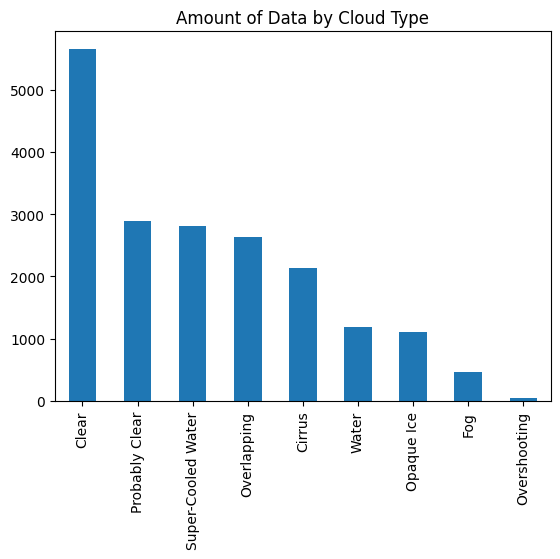

In [ ]:
# Amount of data each cloud type
jumlah_tipe = train["Cloud Type"].value_counts()
persentase_tipe = 100*train["Cloud Type"].value_counts(normalize=True)
df_ct = pd.DataFrame({'jumlah sampel': jumlah_tipe, 'persentase(%)': persentase_tipe})
print(df_ct)
jumlah_tipe.plot(kind='bar', title="Amount of Data by Cloud Type")

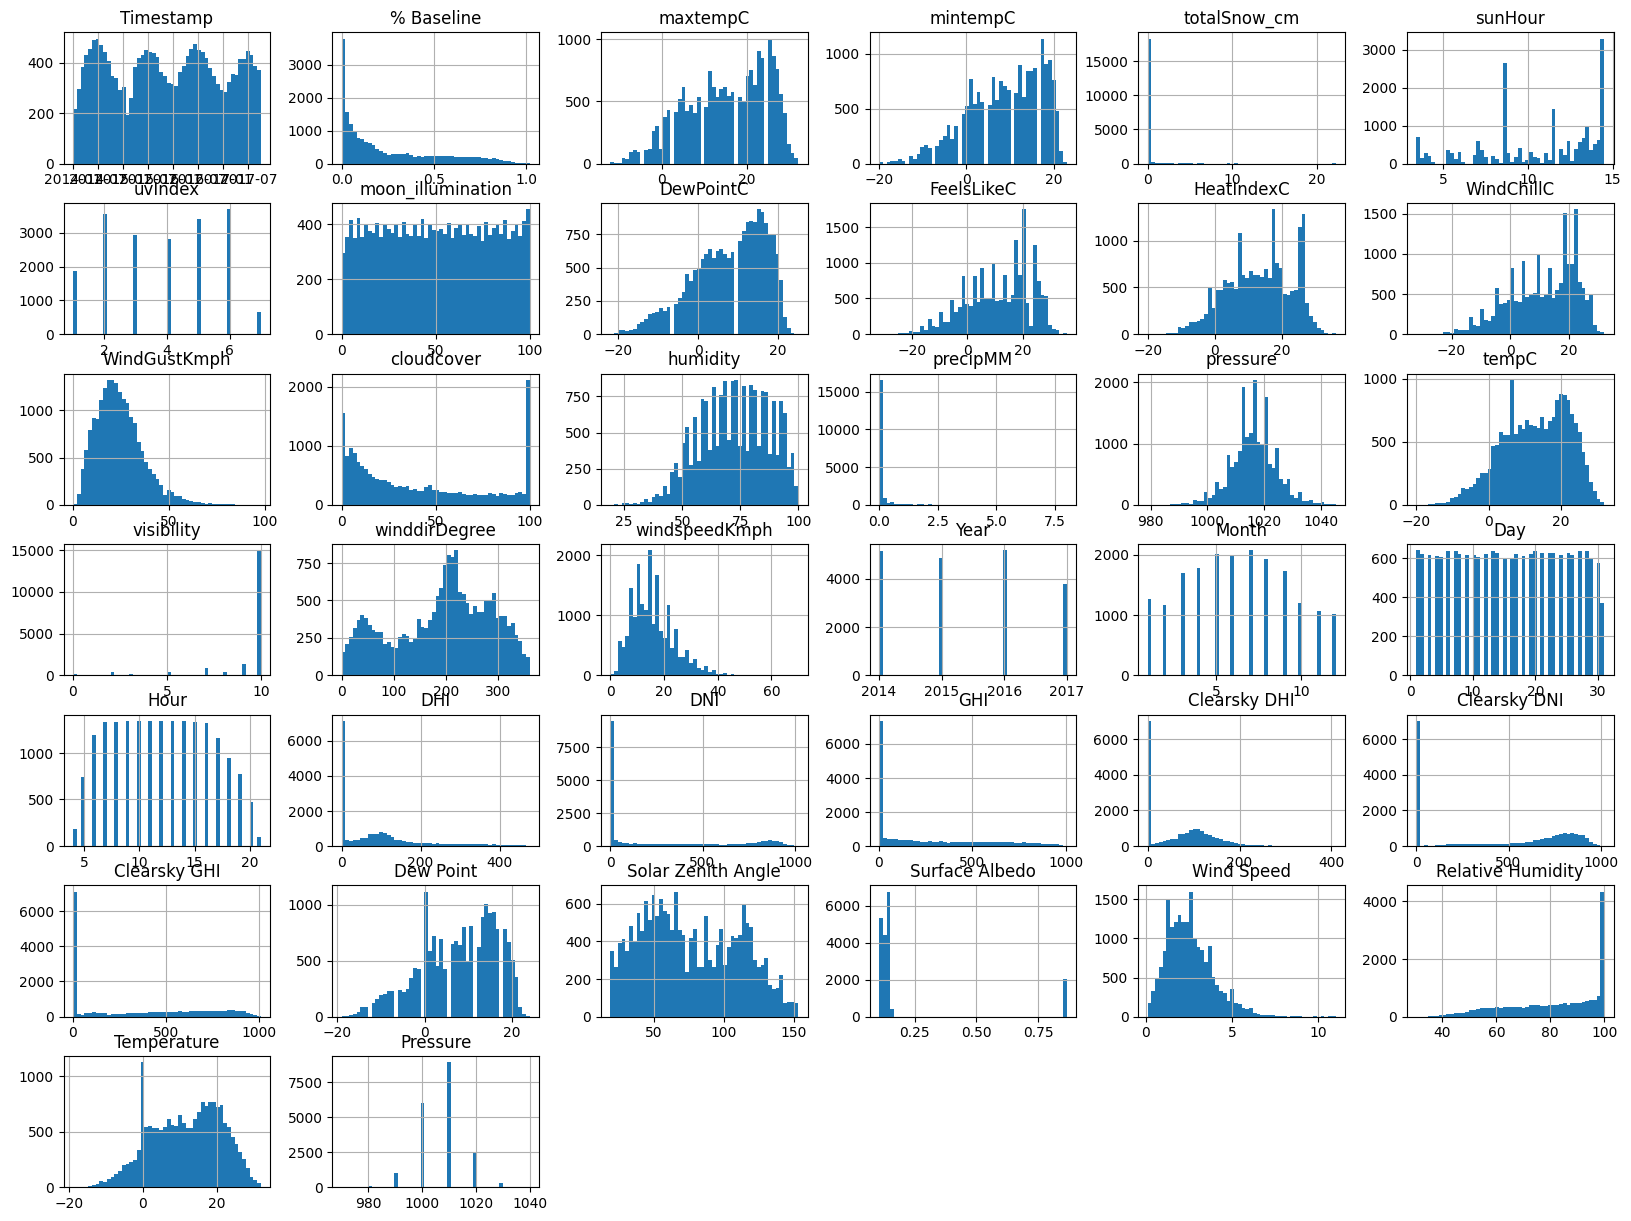

In [ ]:
# Distribution of each columns 
train.hist(bins=50, figsize=(20,15))
plt.show()

From these histogram we can conclude some notes:
- % Baseline : Data has tendencies in below, that means so many pannel less optimal, the data distribution is right skew that will implicate to the model 


### Multivariate Analysis
show relationship two or more variables. 

#### Object Columns: Cloud Type
mean of % Baseline each cloud type, want to know which one has tendencies on more % baseline and which one less. 

C:\Users\Lenovo\AppData\Local\Temp\ipykernel_12432\751186240.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.catplot(x='Cloud Type', y='% Baseline', data=mean_baseline, kind='bar',


Text(0.5, 1.0, 'Mean of % Baseline relative to Cloud Type')

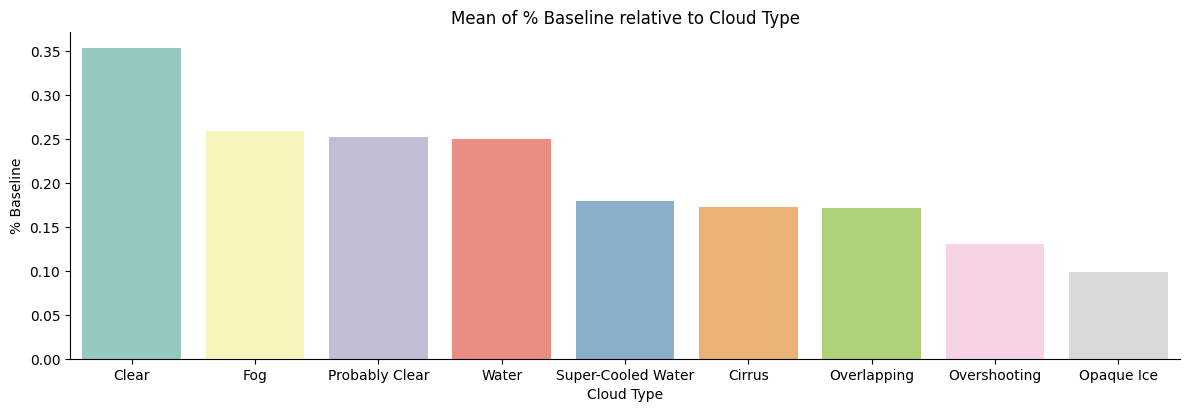

In [ ]:
# % Baseline each Cloud type
mean_baseline = train.groupby('Cloud Type')['% Baseline'].mean().sort_values(ascending=False).reset_index()
# Plot the sorted bar chart
sns.catplot(x='Cloud Type', y='% Baseline', data=mean_baseline, kind='bar', 
            dodge=False, height=4, aspect=3, palette="Set3")
plt.title("Mean of % Baseline relative to Cloud Type")

#### Numerical Features

### % Baseline each Hour

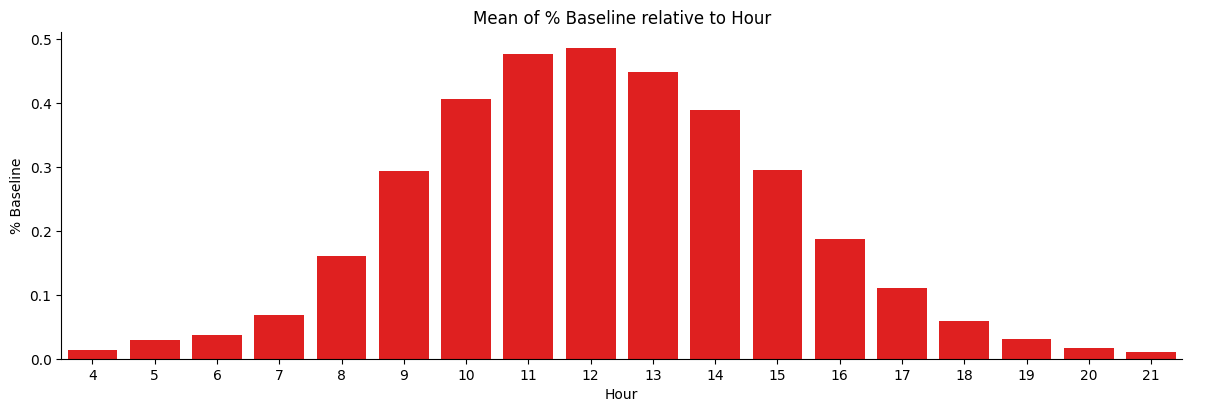

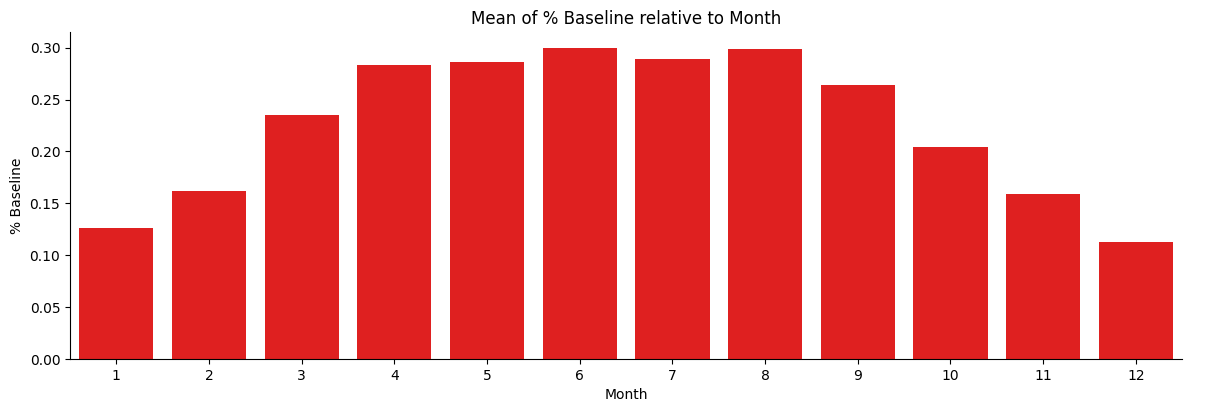

In [ ]:
for i in ['Hour', 'Month']:
    i_baseline = train.groupby(i)['% Baseline'].mean().reset_index()
    sns.catplot(x=f'{i}', y='% Baseline', data=i_baseline, kind='bar', 
                dodge=False, height=4, aspect=3, color='red')
    plt.title(f"Mean of % Baseline relative to {i}")

In [ ]:
# name of each features to recheck
train.columns

Index(['Timestamp', '% Baseline', 'maxtempC', 'mintempC', 'totalSnow_cm',
       'sunHour', 'uvIndex', 'moon_illumination', 'moonrise', 'moonset',
       'sunrise', 'sunset', 'DewPointC', 'FeelsLikeC', 'HeatIndexC',
       'WindChillC', 'WindGustKmph', 'cloudcover', 'humidity', 'precipMM',
       'pressure', 'tempC', 'visibility', 'winddirDegree', 'windspeedKmph',
       'Year', 'Month', 'Day', 'Hour', 'DHI', 'DNI', 'GHI', 'Clearsky DHI',
       'Clearsky DNI', 'Clearsky GHI', 'Cloud Type', 'Dew Point',
       'Solar Zenith Angle', 'Surface Albedo', 'Wind Speed',
       'Relative Humidity', 'Temperature', 'Pressure'],
      dtype='object')

In [ ]:
# make three columns to handling amplitude
train['wind_speed_cos_angle'] = train['Wind Speed'] * np.cos(np.deg2rad(train['winddirDegree']))
train['wind_speed_sin_angle'] = train['Wind Speed'] * np.sin(np.deg2rad(train['winddirDegree']))
train['wind_speed_solar_interaction'] = train['Wind Speed'] * (90 - train['Solar Zenith Angle'])
train['angle_diff'] = np.abs(train['winddirDegree'] - train['Solar Zenith Angle'])

In [ ]:
# working on the testing set 
test['wind_speed_cos_angle'] = test['Wind Speed'] * np.cos(np.deg2rad(test['winddirDegree']))
test['wind_speed_sin_angle'] = test['Wind Speed'] * np.sin(np.deg2rad(test['winddirDegree']))
test['wind_speed_solar_interaction'] = test['Wind Speed'] * (90 - test['Solar Zenith Angle'])
test['angle_diff'] = np.abs(test['winddirDegree'] - test['Solar Zenith Angle'])

In [ ]:
# adding the additional features into list of numerical_columns
numerical_columns.extend(["wind_speed_cos_angle", "wind_speed_sin_angle", "wind_speed_solar_interaction", "angle_diff"])

C:\Users\Lenovo\AppData\Local\Temp\ipykernel_12432\4202814341.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=correlation.index, y=correlation.values, palette='coolwarm')


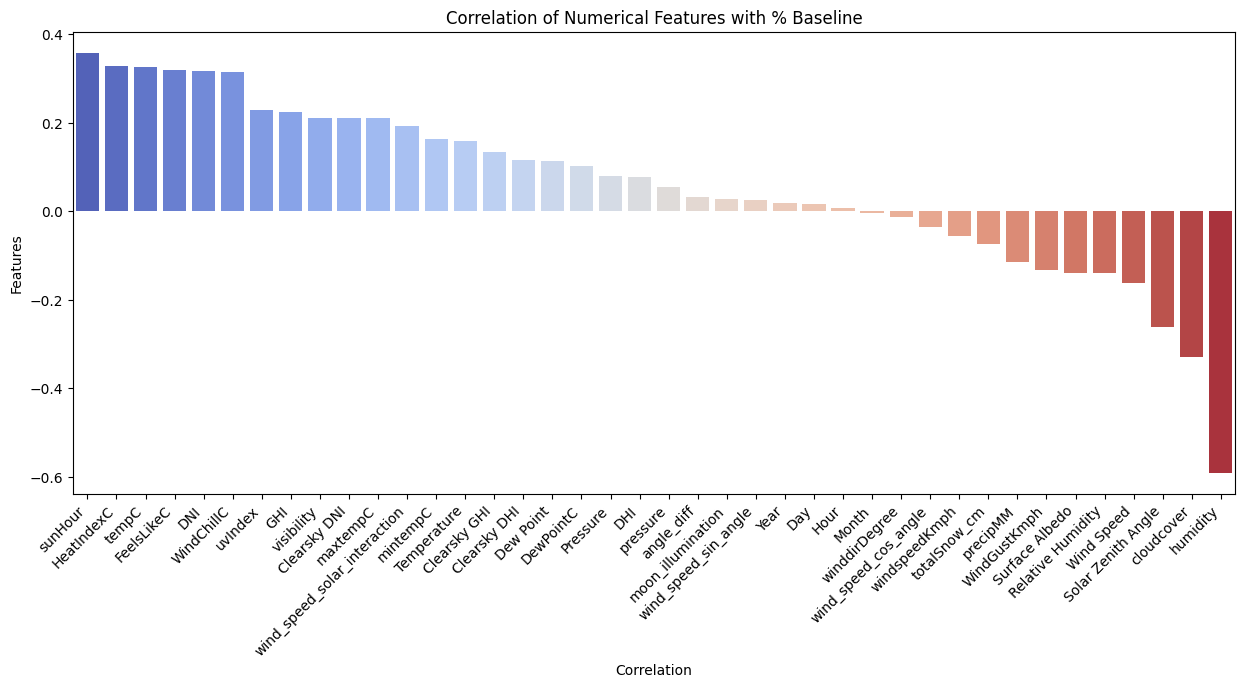

In [ ]:
correlation = train[numerical_columns].corr()['% Baseline'].sort_values(ascending=False)
correlation = correlation.drop(["% Baseline"])
plt.figure(figsize=(15, 6))
sns.barplot(x=correlation.index, y=correlation.values, palette='coolwarm')
plt.xlabel('Correlation')
plt.ylabel('Features')
plt.xticks(rotation=45, ha='right')
plt.title('Correlation of Numerical Features with % Baseline')
plt.show()

Text(0.5, 1.0, 'Correlation Matrix untuk Fitur Numerik ')

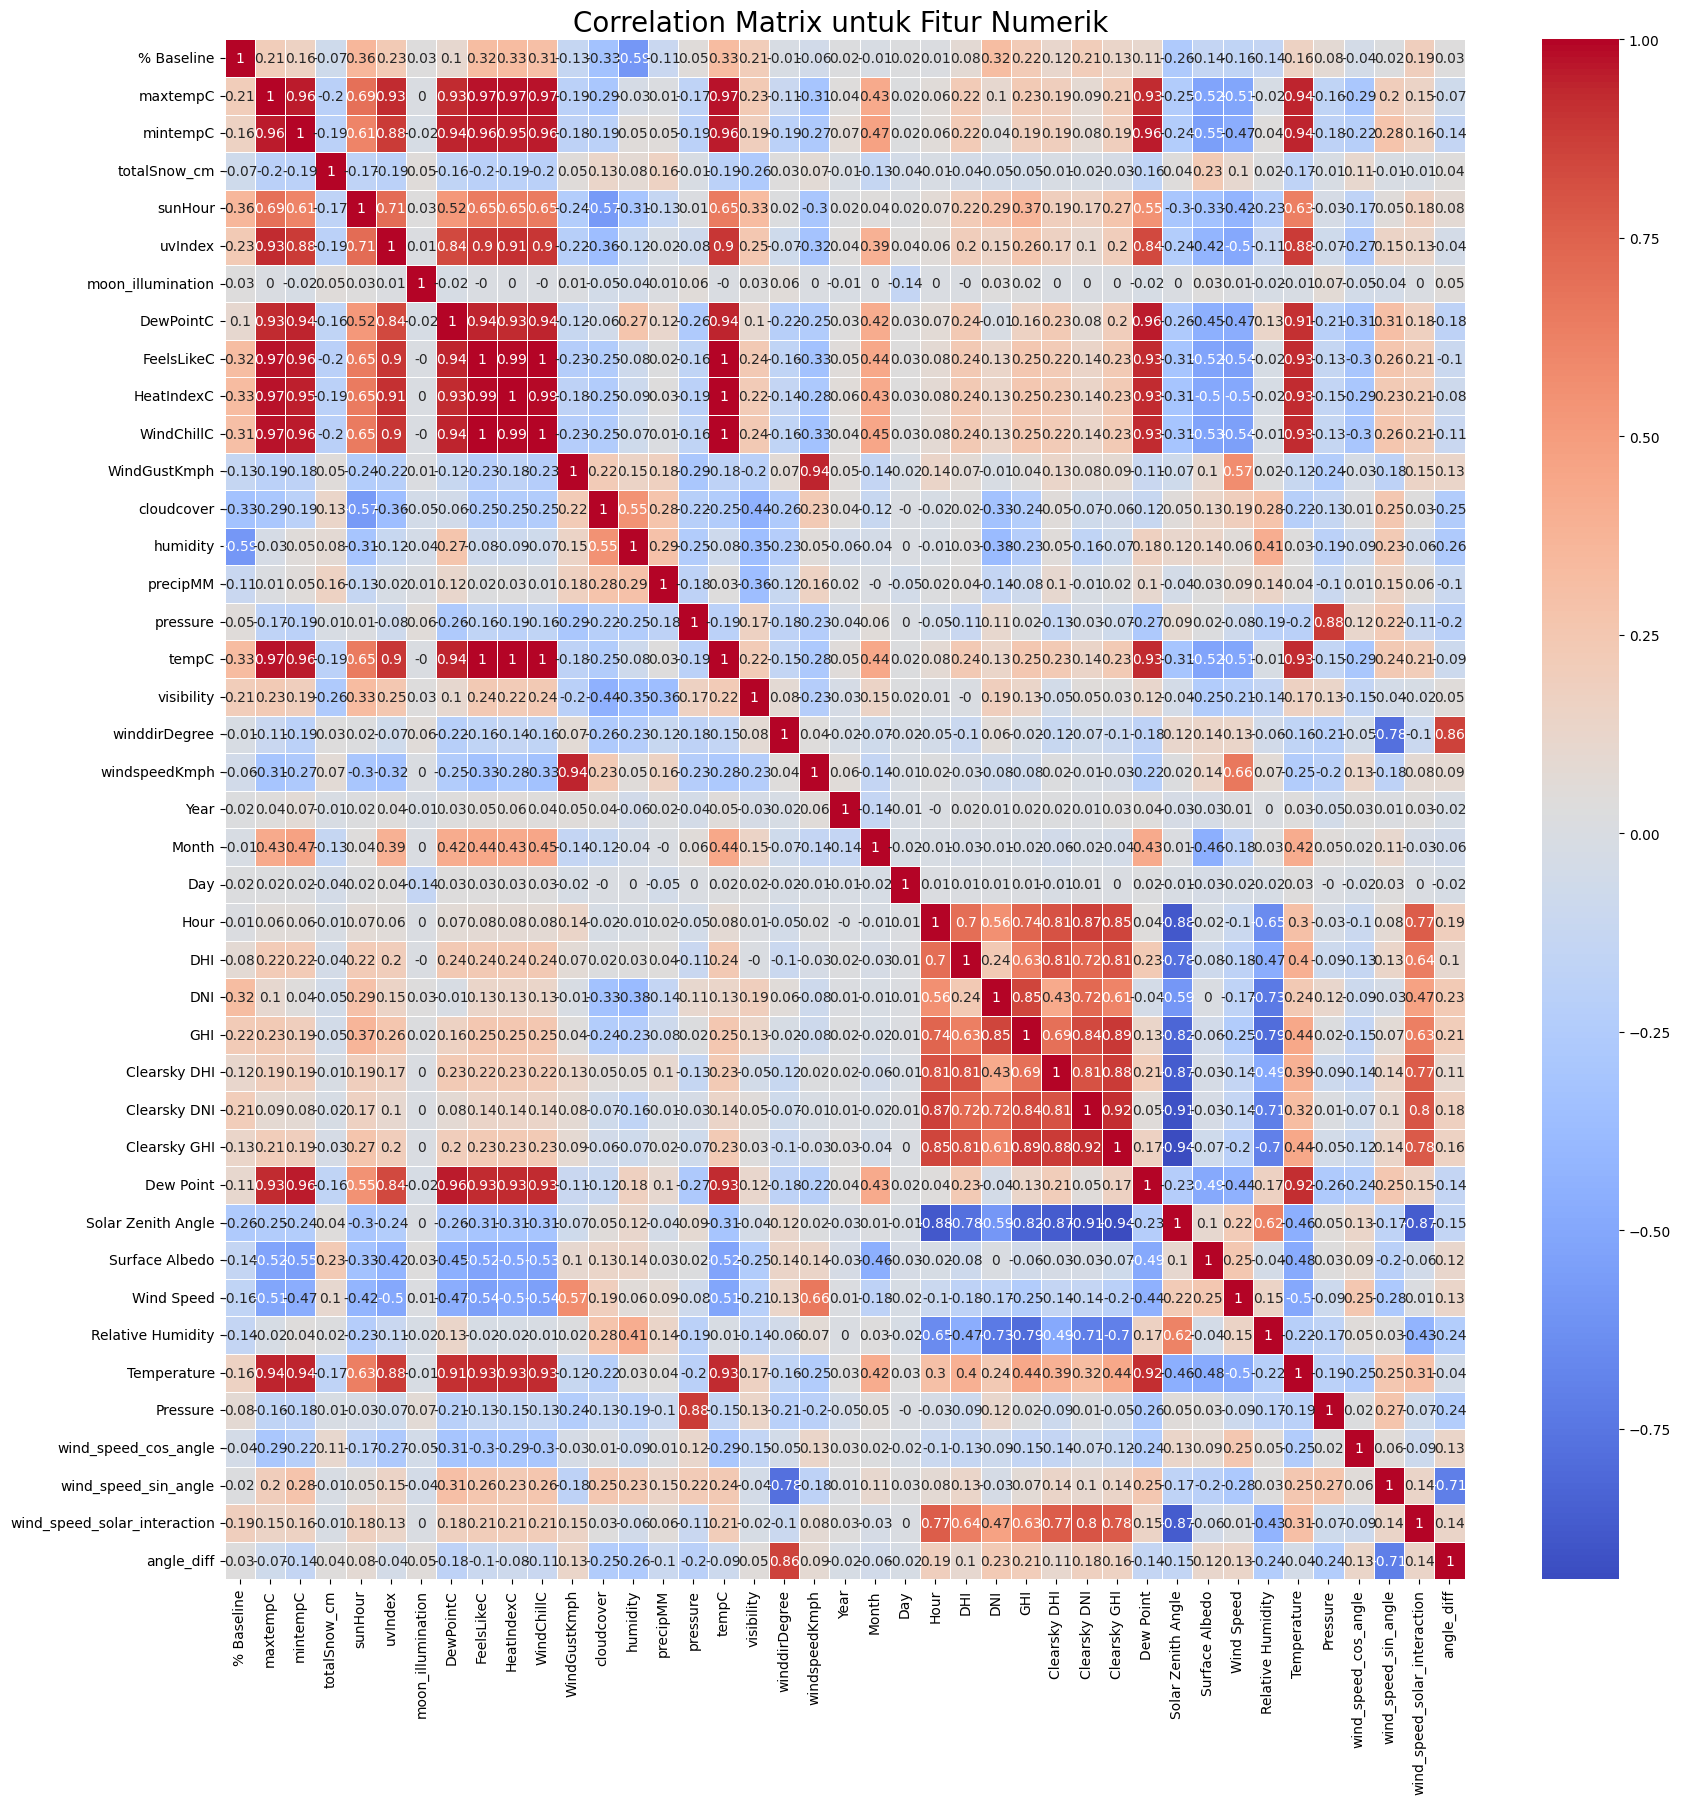

In [ ]:
# heatmap of numerical columns
plt.figure(figsize=(20, 20))
corr_matrix = train[numerical_columns].corr().round(2)
# untuk print nilai dalam kotak 
sns.heatmap(data=corr_matrix, annot=True, cmap='coolwarm',linewidths=0.5,)
plt.title("Correlation Matrix untuk Fitur Numerik ", size=20)

Drop of less correlation would be skip first, because who know it will use to reveal non linear relation like in decision tree.

## Data Preprocessing

### Feature Engineering

#### Season

(array([16071., 16252., 16436., 16617., 16801., 16983., 17167., 17348.]),
 [Text(16071.0, 0, '2014-01'),
  Text(16252.0, 0, '2014-07'),
  Text(16436.0, 0, '2015-01'),
  Text(16617.0, 0, '2015-07'),
  Text(16801.0, 0, '2016-01'),
  Text(16983.0, 0, '2016-07'),
  Text(17167.0, 0, '2017-01'),
  Text(17348.0, 0, '2017-07')])

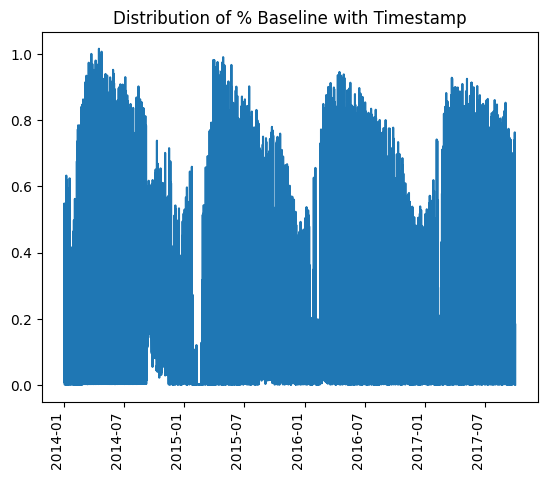

In [ ]:
plt.plot(train["Timestamp"], train["% Baseline"])
plt.title("Distribution of % Baseline with Timestamp")
plt.xticks(rotation=90, ha='right')

In [ ]:
train["Timestamp"].describe()

C:\Users\Lenovo\AppData\Local\Temp\ipykernel_12432\3912383464.py:1: FutureWarning: Treating datetime data as categorical rather than numeric in `.describe` is deprecated and will be removed in a future version of pandas. Specify `datetime_is_numeric=True` to silence this warning and adopt the future behavior now.
  train["Timestamp"].describe()


count                   18942
unique                  18942
top       2014-01-01 07:00:00
freq                        1
first     2014-01-01 07:00:00
last      2017-09-30 18:00:00
Name: Timestamp, dtype: object

In [ ]:
test["Timestamp"].describe()

C:\Users\Lenovo\AppData\Local\Temp\ipykernel_12432\3376349364.py:1: FutureWarning: Treating datetime data as categorical rather than numeric in `.describe` is deprecated and will be removed in a future version of pandas. Specify `datetime_is_numeric=True` to silence this warning and adopt the future behavior now.
  test["Timestamp"].describe()


count                    1077
unique                   1077
top       2017-10-01 06:00:00
freq                        1
first     2017-10-01 06:00:00
last      2017-12-31 16:00:00
Name: Timestamp, dtype: object

In [ ]:
coba = train.copy()
coba['period'] = pd.to_datetime((train["Timestamp"].dt.year).astype(str) +"-" + train["Timestamp"].dt.month.astype(str) + "-"+"01")

In [ ]:
train['Season'] = np.where(
    (train["Timestamp"].dt.month > 11) | (train["Timestamp"].dt.month < 3), "winter",  # Musim Dingin (Desember - Februari)
    np.where(
        train["Timestamp"].dt.month < 6, "spring",  # Musim Semi (Maret - Mei)
        np.where(
            train["Timestamp"].dt.month < 9, "summer",  # Musim Panas (Juni - Agustus)
            "autumn" # Musim Gugur (September - November)
        )
    )
)

In [ ]:
tes = train.groupby(['Season'])['% Baseline'].mean().reset_index()

([0, 1, 2, 3],
 [Text(0, 0, 'autumn'),
  Text(1, 0, 'spring'),
  Text(2, 0, 'summer'),
  Text(3, 0, 'winter')])

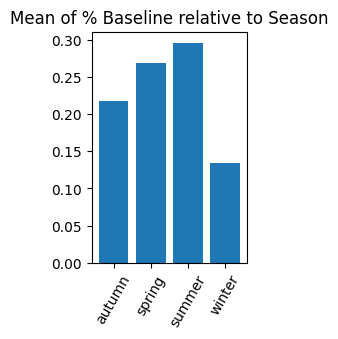

In [ ]:
plt.figure(figsize=(2, 3))
plt.bar(tes["Season"], tes["% Baseline"])
plt.title("Mean of % Baseline relative to Season")
plt.xticks(rotation=60)

In [ ]:
# Working on testing set 
test['Season'] = np.where(
    (test["Timestamp"].dt.month > 11) | (test["Timestamp"].dt.month < 3), "winter",  # Musim Dingin (Desember - Februari)
    np.where(
        test["Timestamp"].dt.month < 6, "spring",  # Musim Semi (Maret - Mei)
        np.where(
            test["Timestamp"].dt.month < 9, "summer",  # Musim Panas (Juni - Agustus)
            "autumn" # Musim Gugur (September - November)
        )
    )
)

In [ ]:
train.drop('Season', axis=1, inplace=True)
test.drop('Season', axis=1, inplace=True)

#### sun_hour and moon_hour

In [ ]:
# look at selected columns
train[["Timestamp", 'moonrise', 'moonset', 'sunrise', 'sunset']]

,Timestamp,moonrise,moonset,sunrise,sunset
0,2014-01-01 07:00:00,6:58 AM,5:05 PM,7:12 AM,4:22 PM
1,2014-01-01 08:00:00,6:58 AM,5:05 PM,7:12 AM,4:22 PM
2,2014-01-01 09:00:00,6:58 AM,5:05 PM,7:12 AM,4:22 PM
3,2014-01-01 10:00:00,6:58 AM,5:05 PM,7:12 AM,4:22 PM
4,2014-01-01 11:00:00,6:58 AM,5:05 PM,7:12 AM,4:22 PM
...,...,...,...,...,...
18937,2017-09-30 14:00:00,2:48 PM,12:05 AM,5:40 AM,5:26 PM
18938,2017-09-30 15:00:00,2:48 PM,12:05 AM,5:40 AM,5:26 PM
18939,2017-09-30 16:00:00,2:48 PM,12:05 AM,5:40 AM,5:26 PM
18940,2017-09-30 17:00:00,2:48 PM,12:05 AM,5:40 AM,5:26 PM


In [ ]:
# change sunrise features into datetime format 
train["sunrise"] = pd.to_datetime(train["Timestamp"].dt.date.astype(str) + " " + train["sunrise"], format="%Y-%m-%d %I:%M %p")
train["sunset"] = pd.to_datetime(train["Timestamp"].dt.date.astype(str) + " " + train["sunset"], format="%Y-%m-%d %I:%M %p")

In [ ]:
# Working on testing set
test["sunrise"] = pd.to_datetime(test["Timestamp"].dt.date.astype(str) + " " + test["sunrise"], format="%Y-%m-%d %I:%M %p")
test["sunset"] = pd.to_datetime(test["Timestamp"].dt.date.astype(str) + " " + test["sunset"], format="%Y-%m-%d %I:%M %p")

In [ ]:
# After checking, we decide to manipulate with change "no moonrise" into moonset (vice versa)
train.loc[train['moonrise'] == 'No moonrise', 'moonrise'] = train.loc[train['moonrise'] == 'No moonrise', 'moonset']
train.loc[train['moonset'] == 'No moonset', 'moonset'] = train.loc[train['moonset'] == 'No moonset', 'moonrise']

In [ ]:
# Working on testing set
test.loc[test['moonrise'] == 'No moonrise', 'moonrise'] = test.loc[test['moonrise'] == 'No moonrise', 'moonset']
test.loc[test['moonset'] == 'No moonset', 'moonset'] = test.loc[test['moonset'] == 'No moonset', 'moonrise']

In [ ]:
# change moonrise & moonset features into datetime format 
train["moonset"] = pd.to_datetime(train["Timestamp"].dt.date.astype(str) + " " + train["moonset"], format="%Y-%m-%d %I:%M %p")
train["moonrise"] = pd.to_datetime(train["Timestamp"].dt.date.astype(str) + " " + train["moonrise"], format="%Y-%m-%d %I:%M %p")

In [ ]:
# Working on testing set
test["moonset"] = pd.to_datetime(test["Timestamp"].dt.date.astype(str) + " " + test["moonset"], format="%Y-%m-%d %I:%M %p")
test["moonrise"] = pd.to_datetime(test["Timestamp"].dt.date.astype(str) + " " + test["moonrise"], format="%Y-%m-%d %I:%M %p")

In [ ]:
# recheck the columns after manipulate
train[["Timestamp", 'moonrise', 'moonset', 'sunrise', 'sunset']].head()

,Timestamp,moonrise,moonset,sunrise,sunset
0,2014-01-01 07:00:00,2014-01-01 06:58:00,2014-01-01 17:05:00,2014-01-01 07:12:00,2014-01-01 16:22:00
1,2014-01-01 08:00:00,2014-01-01 06:58:00,2014-01-01 17:05:00,2014-01-01 07:12:00,2014-01-01 16:22:00
2,2014-01-01 09:00:00,2014-01-01 06:58:00,2014-01-01 17:05:00,2014-01-01 07:12:00,2014-01-01 16:22:00
3,2014-01-01 10:00:00,2014-01-01 06:58:00,2014-01-01 17:05:00,2014-01-01 07:12:00,2014-01-01 16:22:00
4,2014-01-01 11:00:00,2014-01-01 06:58:00,2014-01-01 17:05:00,2014-01-01 07:12:00,2014-01-01 16:22:00


In [ ]:
# sun_hour di train set 
train["sun_hour"] = np.where((train["Timestamp"] > train["sunrise"]) & (train["Timestamp"] < train["sunset"]), 1, 0)
# sun_hour di test set
test["sun_hour"] = np.where((test["Timestamp"] > test["sunrise"]) & (test["Timestamp"] < test["sunset"]), 1, 0)

In [ ]:
# moon hour di train set 
train["moon_hour"] = np.where((train["Timestamp"] > train["moonrise"]) & (train["Timestamp"] < train["moonset"]), 1, 0)
# sun_hour di test set
test["moon_hour"] = np.where((test["Timestamp"] > test["moonrise"]) & (test["Timestamp"] < test["moonset"]), 1, 0)

#### Long Day (Panjang Hari Relatif dengan Matahari)

In [ ]:
# making new features into training set 
train["long_day_minutes"] = (train["sunset"] - train["sunrise"]).dt.total_seconds()/60

In [ ]:
# making new features into testing set 
test["long_day_minutes"] = (test["sunset"] - test["sunrise"]).dt.total_seconds()/60

#### Morning, Noon, Afternoon 

In [ ]:
# making new features, the idea is about the day divide into 4 parts (evening, morning, noon, and afternoon)
train["intense_sunrise"] = np.where(train["sun_hour"]==0, "evening", 
                                   np.where(
                                       train["Timestamp"].dt.hour < train["sunrise"].dt.hour+(train["sunset"].dt.hour - train["sunrise"].dt.hour)/3, "morning", 
                                       np.where(
                                           train["Timestamp"].dt.hour <= train["sunrise"].dt.hour+(train["sunset"].dt.hour - train["sunrise"].dt.hour)*2/3, "noon", "afternoon" 
                                       )
                                   )
                                   ) 

C:\Users\Lenovo\AppData\Local\Temp\ipykernel_12432\1899795977.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.catplot(x='intense_sunrise', y='% Baseline', data=intense_sunrise, kind='bar',


Text(0.5, 1.0, 'Mean of % Baseline relative to Day Division')

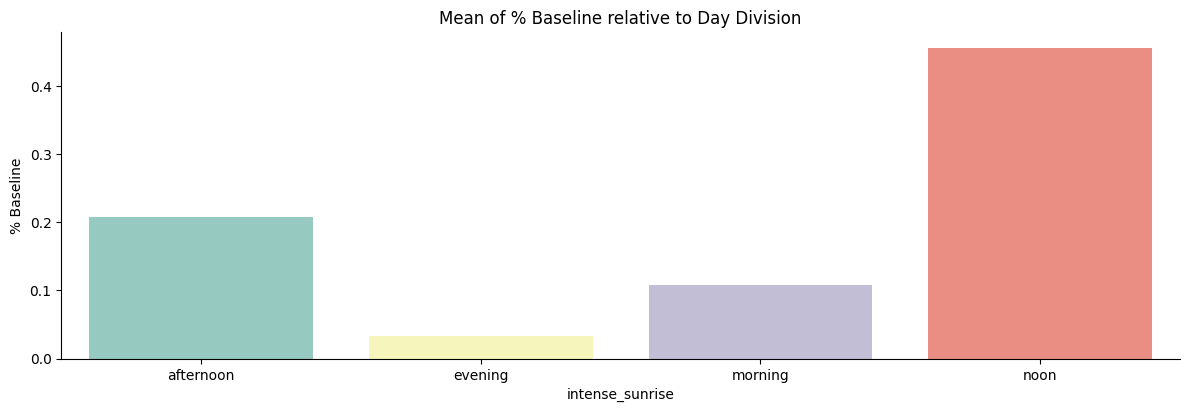

In [ ]:
intense_sunrise = train.groupby("intense_sunrise")["% Baseline"].mean().reset_index()
sns.catplot(x='intense_sunrise', y='% Baseline', data=intense_sunrise, kind='bar', 
            dodge=False, height=4, aspect=3, palette="Set3")
plt.title("Mean of % Baseline relative to Day Division")

In [ ]:
# working on testing set 
test["intense_sunrise"] = np.where(test["sun_hour"]==0, "evening", 
                                   np.where(
                                       test["Timestamp"].dt.hour < test["sunrise"].dt.hour+(test["sunset"].dt.hour - test["sunrise"].dt.hour)/3, "morning", 
                                       np.where(
                                           test["Timestamp"].dt.hour <= test["sunrise"].dt.hour+(test["sunset"].dt.hour - test["sunrise"].dt.hour)*2/3, "noon", "afternoon" 
                                       )
                                   )
                                   ) 

In [ ]:
# One hot encoding 
train = pd.concat([train, pd.get_dummies(train['intense_sunrise'], prefix='intense_sunrise')], axis=1)
test = pd.concat([test, pd.get_dummies(test['intense_sunrise'], prefix='intense_sunrise')], axis=1)

In [ ]:
# Dropping bridging column
train = train.drop(['intense_sunrise', 'moonrise', 'moonset', 'sunrise', 'sunset'], axis=1)
test = test.drop(['intense_sunrise', 'moonrise', 'moonset', 'sunrise', 'sunset'], axis=1)

#### Encoding Cloud Type 

In [ ]:
# One hot encoding Cloud Type
train = pd.concat([train, pd.get_dummies(train['Cloud Type'], prefix='Cloud Type')], axis=1)
test = pd.concat([test, pd.get_dummies(test['Cloud Type'], prefix='Cloud Type')], axis=1)

In [ ]:
# Working One Hot into testing set 
train.drop(["Cloud Type"], axis=1, inplace=True)
test.drop(["Cloud Type"], axis=1, inplace=True)

#### Time Features Extraction

In [ ]:
# features of jumlah_jam is number of hours in the time after the first data 
train["jumlah_jam"] = ((train["Year"] - 2014)*365.25 + (train["Month"] - 1)*30 + (train["Day"]-1))*24 + train["Hour"]

In [ ]:
# features of jumlah_jam is number of hours in the time after the first data 
test["jumlah_jam"] = ((test["Year"] - 2014)*365.25 + (test["Month"] - 1)*30 + (test["Day"]-1))*24 + test["Hour"]

In [ ]:
# making cyclical variables make sense if patterns occur 24/7/31
def time_features(_df: pd.DataFrame, data_type:str='train') -> pd.DataFrame:
    df = _df.copy()
    hour = df["Hour"]
    dm = df["Day"]
    dw = train["Timestamp"].dt.dayofweek + 1
    month = df["Month"]
    for time, col in zip([hour, dm, dw, month], ['hour', 'dm', 'dw', 'month']):
        time_range = {
            'hour':24, 
            'dm': 31,
            'dw': 7,
            'month':12,
        }
        df[f'{col}_sin'] = np.sin(time*(2*np.pi/time_range[col]))
        df[f'{col}_cos'] = np.cos(time*(2*np.pi/time_range[col]))
    return df

In [ ]:
train = train[train["month"]>=10]

In [ ]:
# cyclical working on training set 
train_preprocess = time_features(train)

In [ ]:
# cyclical working on testing set 
test_preprocess = time_features(test)

In [ ]:
# drop Timestamp
train_preprocess.drop(['Timestamp'], axis=1, inplace=True)
test_preprocess.drop(['Timestamp'], axis=1, inplace=True)

### Train Test Split

In [ ]:
# make X and y division 
X = train_preprocess.drop(["% Baseline"], axis=1)
y = train_preprocess["% Baseline"]

In [ ]:
# X for testing
X_test = test_preprocess.drop(["% Baseline"], axis=1)

In [ ]:
# splitting for train and validation and sequentials (not random)
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.1, random_state=STATE)

In [ ]:
# check number of data each set of data
print(f'Total # of sample in whole dataset: {len(X)}')
print(f'Total # of sample in train dataset: {len(X_train)}')
print(f'Total # of sample in test dataset: {len(X_val)}')

Total # of sample in whole dataset: 18942
Total # of sample in train dataset: 17047
Total # of sample in test dataset: 1895


### Standardization
It will help machine learning algorithm performance better, reaching more on convergence for numerical features

In [ ]:
# check columns that not belong into numerical_columns 
for i in X_train.columns:
    if i not in numerical_columns:
        print(i)

sun_hour
moon_hour
long_day_minutes
intense_sunrise_afternoon
intense_sunrise_evening
intense_sunrise_morning
intense_sunrise_noon
Cloud Type_Cirrus
Cloud Type_Clear
Cloud Type_Fog
Cloud Type_Opaque Ice
Cloud Type_Overlapping
Cloud Type_Overshooting
Cloud Type_Probably Clear
Cloud Type_Super-Cooled Water
Cloud Type_Water
local_solar_time
hour_angle
jumlah_jam
hour_sin
hour_cos
dm_sin
dm_cos
dw_sin
dw_cos
month_sin
month_cos


In [ ]:
# Adding to standardization
for i in ['Year', 'Month', 'Day', 'Hour', 'jumlah_jam', 'long_day_minutes', "local_solar_time", "hour_angle"]:
    numerical_columns.append(i)
# remove unnecassary columns 
for i in ["% Baseline"]:
    numerical_columns.remove(i)

In [ ]:
# standardization define
scaler = StandardScaler()

In [ ]:
# fiting standardization
scaler.fit(X_train[numerical_columns])

StandardScaler()

In [ ]:
# transform numerical columns 
X_train[numerical_columns] = scaler.transform(X_train.loc[:, numerical_columns])
X_val[numerical_columns] = scaler.transform(X_val.loc[:, numerical_columns])
X_test[numerical_columns] = scaler.transform(X_test.loc[:, numerical_columns])

In [ ]:
# checking top 5 training standardization by index
X_train[numerical_columns].head()

,maxtempC,mintempC,totalSnow_cm,sunHour,uvIndex,moon_illumination,DewPointC,FeelsLikeC,HeatIndexC,WindChillC,...,wind_speed_solar_interaction,angle_diff,Year,Month,Day,Hour,jumlah_jam,long_day_minutes,local_solar_time,hour_angle
9090,0.077829,0.021476,-0.130453,0.250164,0.085850,-1.209512,-0.303206,0.048578,-0.042115,0.077207,...,0.329006,0.536833,-0.370182,1.197068,-0.085069,1.161846,-0.091411,-0.786099,1.108191,1.108191
10305,-1.087751,-1.043443,-0.130453,-0.588471,-1.633876,1.040809,-0.852619,-1.071775,-1.078094,-1.080902,...,-2.052977,0.048135,0.552270,-1.711671,1.275535,-1.422258,0.179727,-1.416053,-1.443858,-1.443858
51,-1.829484,-1.871712,-0.130453,-0.588471,-1.060634,0.140681,-2.281091,-1.761224,-1.699682,-1.793584,...,-0.180695,1.261085,-1.292633,-1.711671,-0.765372,-0.012747,-1.720040,-1.661490,0.036847,0.036847
4007,1.243409,0.613097,-0.130453,0.280115,1.232334,-1.001790,1.015383,1.341294,1.408256,1.235316,...,-0.067893,0.889751,-1.292633,0.873875,1.275535,-0.247666,-1.065097,-0.377038,-0.258134,-0.258134
5603,-2.041408,-2.108361,0.116804,-1.936276,-1.060634,0.036820,-1.511913,-2.019767,-1.803280,-2.060840,...,0.457494,-1.196836,-0.370182,-1.388478,1.162151,0.222171,-0.673253,-0.777918,0.166890,0.166890


## Modelling 

### Model Selection

In [299]:
# here are models that we selected to compare them, then selected best of them, boosting with hypertunning
models = {
    'ridge': linear_model.RidgeCV(),
    'rf': ensemble.RandomForestRegressor(n_jobs=-1, random_state=STATE),
    'xgboost': xgb.XGBRegressor(n_estimators=200, random_state=STATE),
    'catboost': cb.CatBoostRegressor(verbose=0, random_state=STATE),
    'lightgbm': lgbm.LGBMRegressor(n_estimators=1000, random_state=STATE)
}

In [300]:
# dict for amount of error
oof_predictions = dict()

In [301]:
# Root Mean Square Error with Cross Validation 
def get_rmse(y_pred: np.array, y_true: np.array, folds:int=5)-> np.array:
    scores=np.zeros(folds)
    dpf = int(np.ceil(len(y_pred)/folds))
    for i in range(folds):
        start = i*dpf
        end = min((i+1)*dpf, len(y_pred))
        scores[i] = mse(y_pred[start:end], y_true[start:end], squared=False)
    return scores

In [302]:
# Compare each model
for model_name, model in models.items():
    start = time.perf_counter()
    oof_predictions[model_name] = cvp(model, X_train, y_train)
    end = time.perf_counter()
    scores=get_rmse(oof_predictions[model_name], y_train)

    print(f"""{model_name}'s Performance in RMSE
          time: {end-start:.3f} secs
          mean: {np.mean(scores):.3f}
          std: {np.std(scores):.3f}
          max: {np.max(scores):.3f}
          min: {np.min(scores):.3f}
""")

ridge's Performance in RMSE
          time: 3.571 secs
          mean: 0.123
          std: 0.002
          max: 0.125
          min: 0.121

rf's Performance in RMSE
          time: 163.813 secs
          mean: 0.080
          std: 0.002
          max: 0.083
          min: 0.077

xgboost's Performance in RMSE
          time: 12.510 secs
          mean: 0.076
          std: 0.002
          max: 0.078
          min: 0.075

catboost's Performance in RMSE
          time: 76.871 secs
          mean: 0.077
          std: 0.001
          max: 0.078
          min: 0.075

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.005686 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 5804
[LightGBM] [Info] Number of data points in the train set: 13637, number of used features: 

In [303]:
# feature imporance of LGBM 
selected_model = models['lightgbm']
selected_model.fit(X_train, y_train)

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.016536 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5819
[LightGBM] [Info] Number of data points in the train set: 17047, number of used features: 67
[LightGBM] [Info] Start training from score 0.242390


LGBMRegressor(n_estimators=1000, random_state=123)

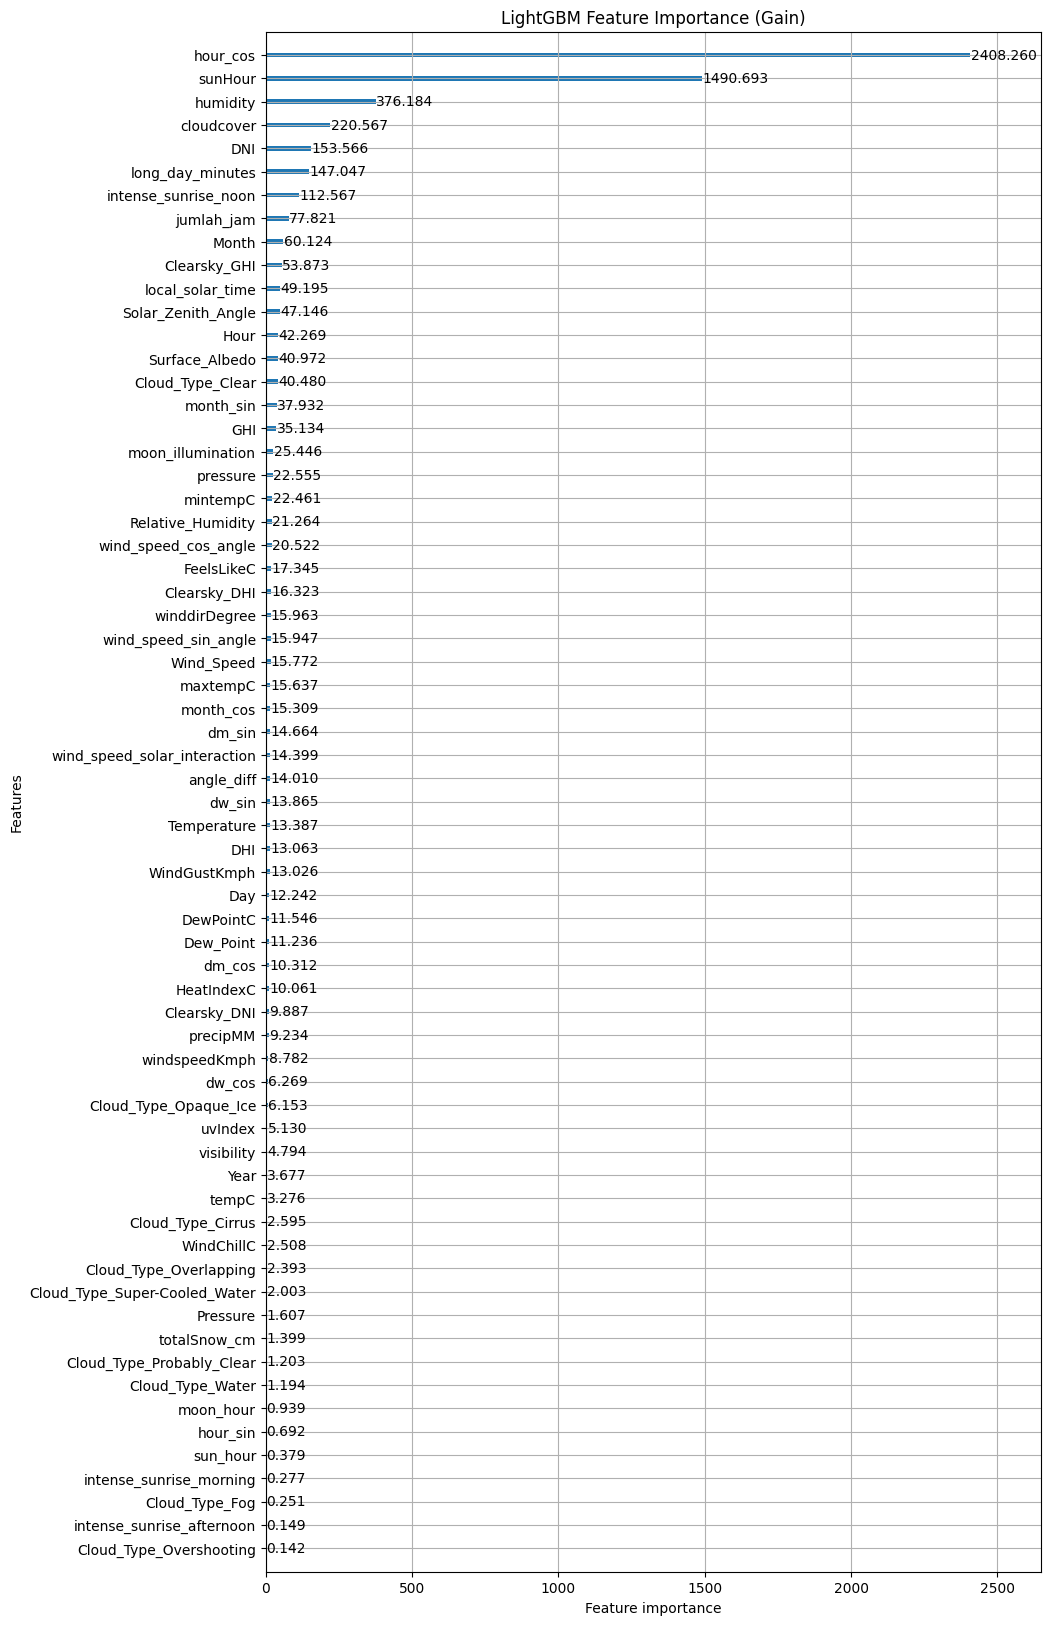

In [304]:
# What is Features that achieve best gain
lgbm.plot_importance(selected_model, importance_type="gain", figsize=(10, 20), title="LightGBM Feature Importance (Gain)")
plt.show()

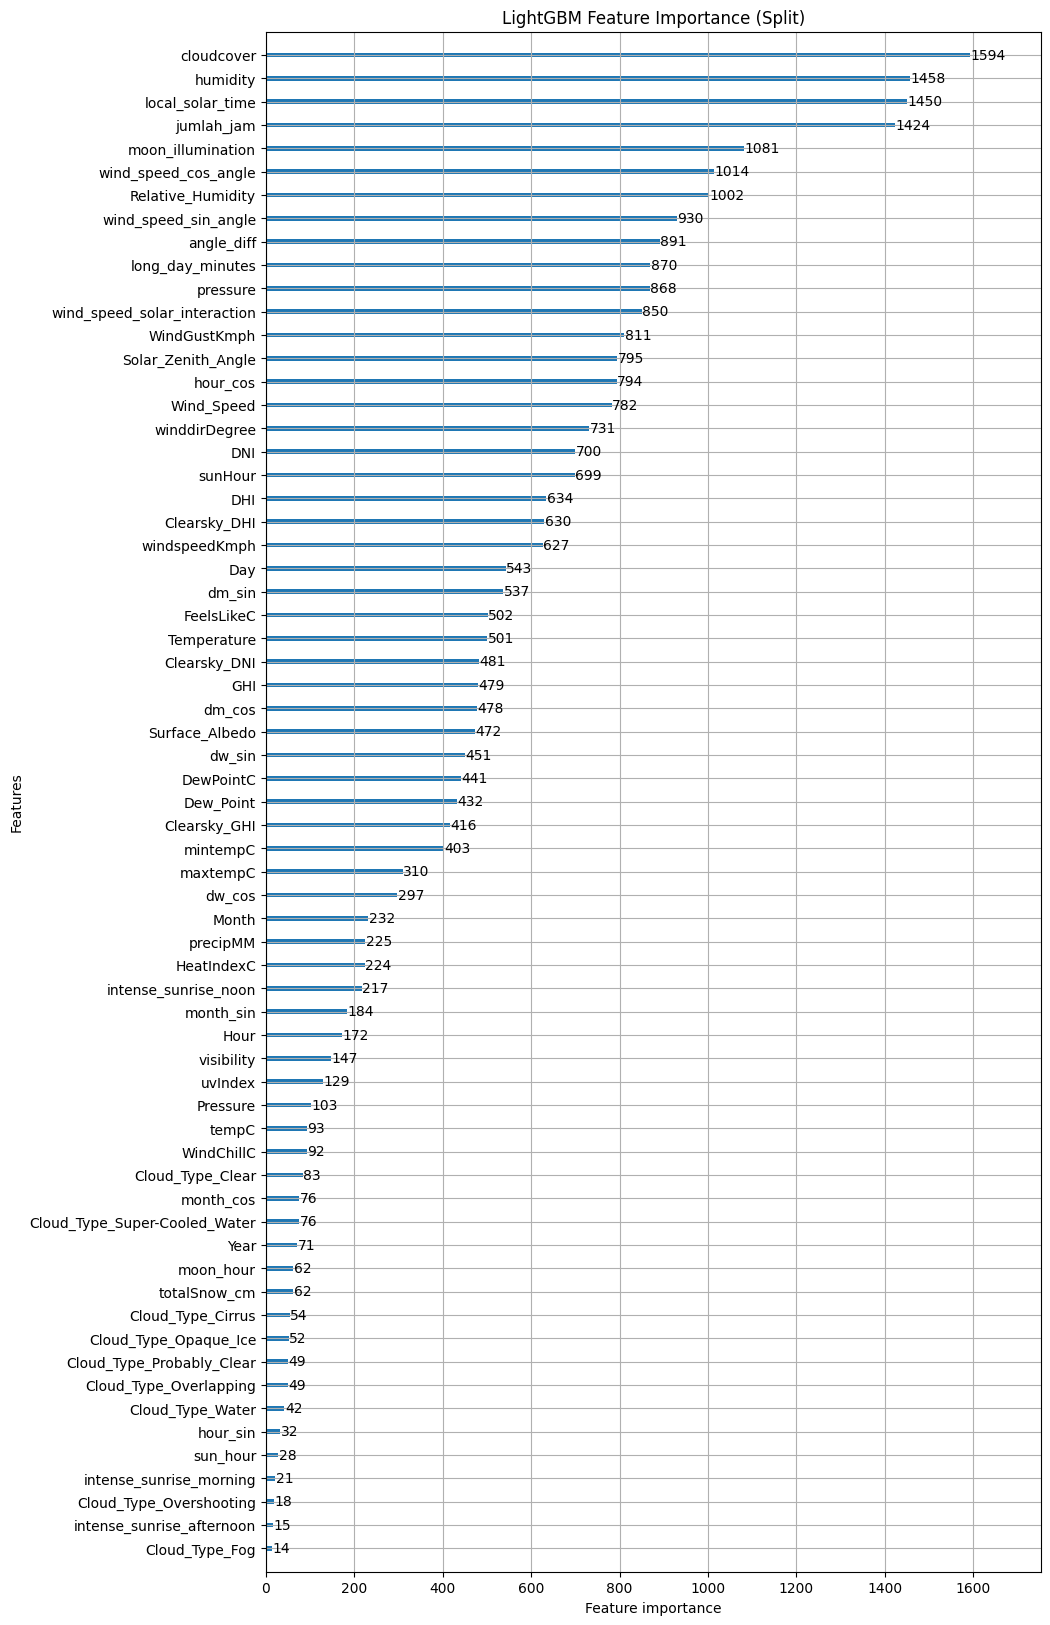

In [306]:
# What is Features that often used to split the data
lgbm.plot_importance(selected_model, importance_type="split", figsize=(10, 20), title="LightGBM Feature Importance (Split)")
plt.show()

In [307]:
# validation of base model
y_val_pred = selected_model.predict(X_val)
# means of cross val
np.mean(get_rmse(y_val_pred, y_val))

0.06381960689211179

In [308]:
# value of baseline under 0
sum(y_val_pred < 0)

80

In [309]:
# count value of baseline over 1
sum(y_val_pred > 1)

0

In [311]:
# change value to be 0 if under 0
for i in range(len(y_val_pred)):
    if y_val_pred[i] < 0:
        y_val_pred[i] = 0.00
# change value to be 1 if over 1
for i in range(len(y_val_pred)):
    if y_val_pred[i] > 1:
        y_val_pred[i] = 1
# checking again 
sum(y_val_pred < 0)

0

In [312]:
# check again cross val of validation base model
np.mean(get_rmse(y_val_pred, y_val))

0.06370403335383638

In [313]:
# how about train
y_pred = selected_model.predict(X_train)
for i in range(len(y_pred)):
    if y_pred[i] < 0:
        y_pred[i] = 0.00
np.mean(get_rmse(y_pred, y_train))

0.020752749721053808

In [314]:
# How about CatBoost (as references)
selected_model = models['catboost']
selected_model.fit(X_train, y_train)

feature_importances = selected_model.get_feature_importance()
feature_names = train.columns

sorted_idx = np.argsort(feature_importances)[::]


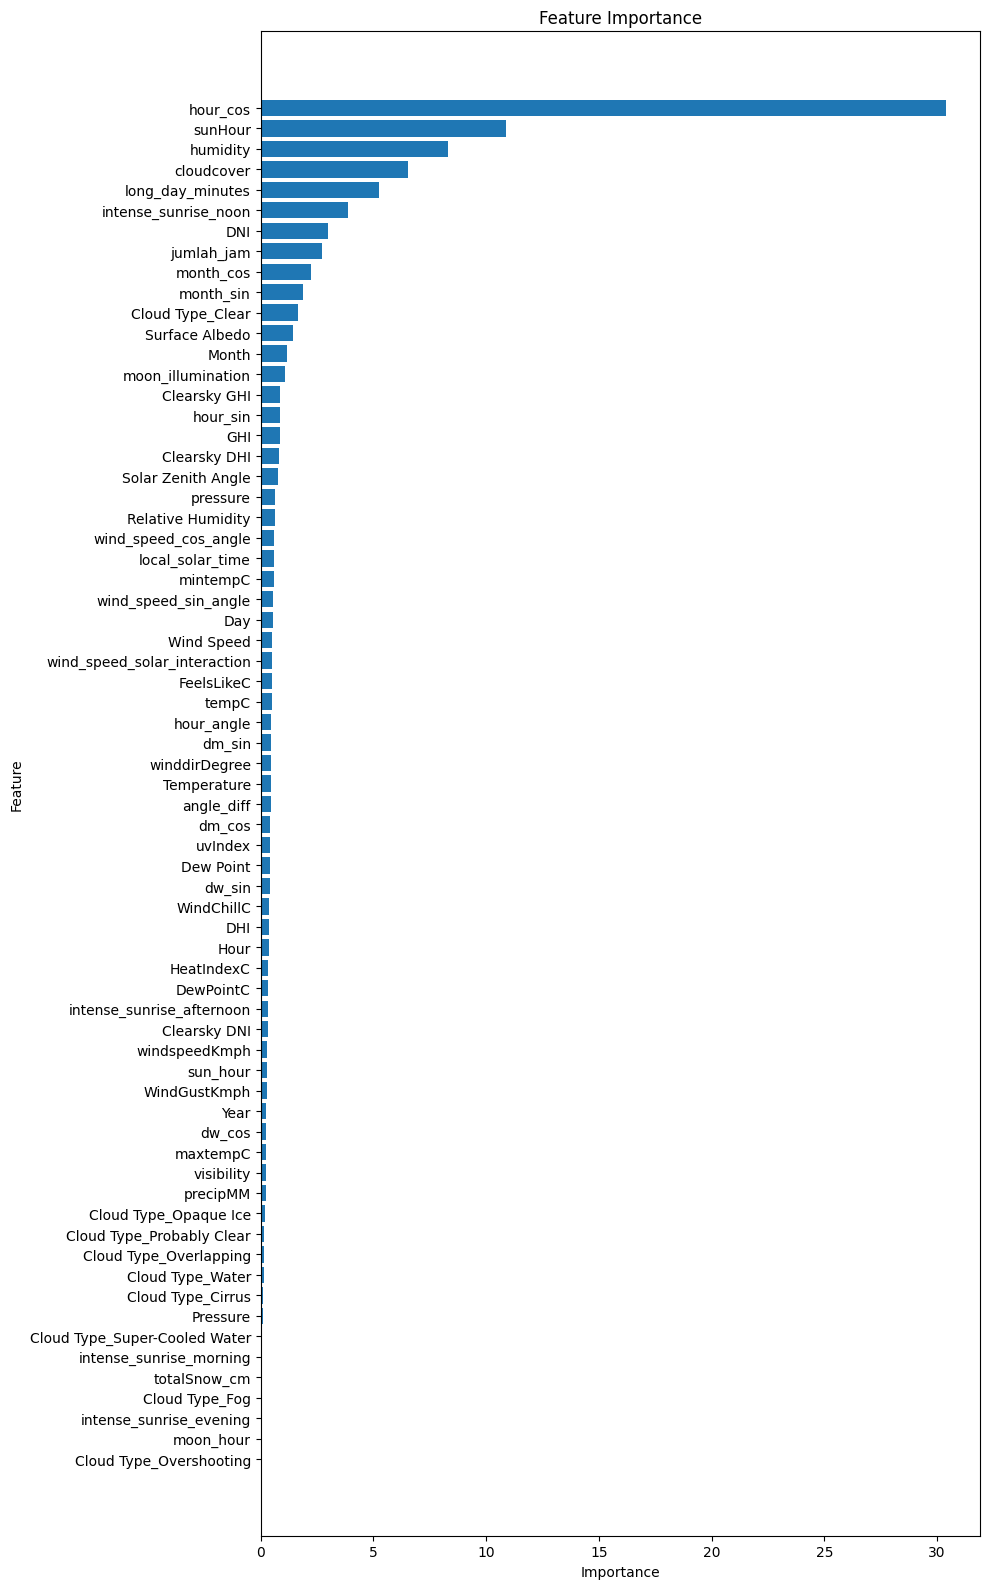

In [315]:
# Plot feature importance of catboost 
plt.figure(figsize=(10, 16))
plt.barh(range(len(feature_importances)), feature_importances[sorted_idx], align='center')
plt.yticks(range(len(feature_importances)), np.array(X_train.columns)[sorted_idx])
plt.title('Feature Importance')
plt.ylabel('Feature')
plt.xlabel('Importance')
plt.tight_layout() # Adjust layout to fit feature names
plt.show()

<Axes: xlabel='Timestamp', ylabel='% Baseline'>

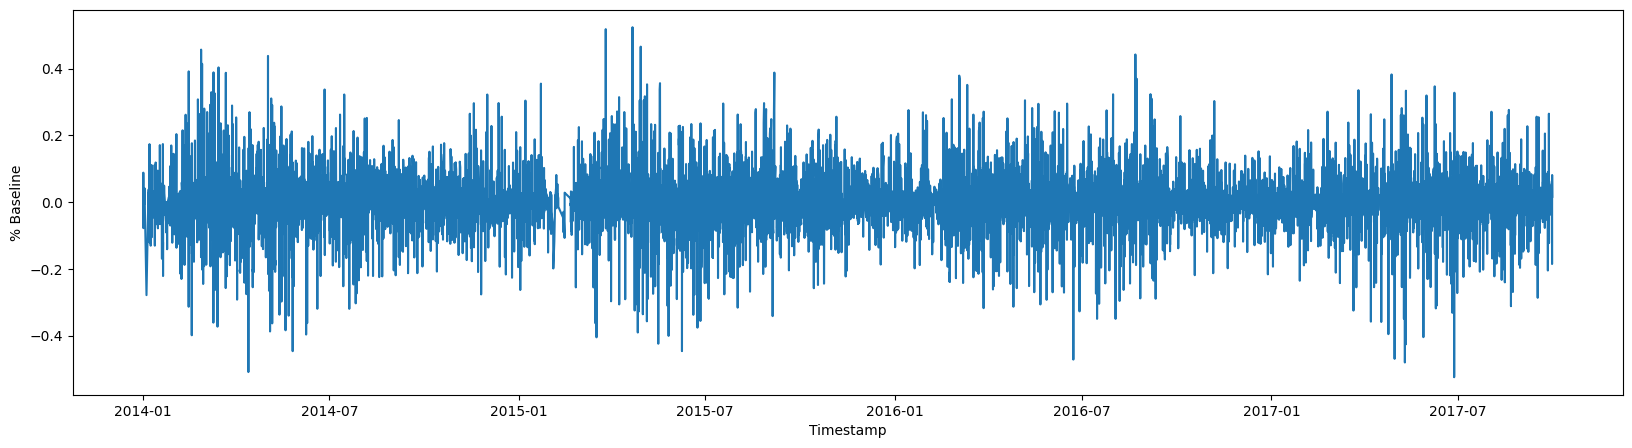

In [566]:
# what went wrong ? based on oof
fig, ax = plt.subplots(1, 1, figsize=(20, 5))

sns.lineplot(
    x=train["Timestamp"],
    y=y_train - oof_predictions['catboost'],
)

### Hypertuning
we use Optuna, smart technique called Bayesian Optimization to find best hyperparameter

In [316]:

def objective(trial):
    params = {
        "objective": "regression",
        "metric": "rmse",
        "n_estimators":1000,
        "verbosity": -1,
        "bagging_freq":1,
        "learning_rate":trial.suggest_float("learning_rate", 1e-3, 0.1, log=True),
        "num_leaves": trial.suggest_int("num_leaves", 2, 2**10),
        "subsample":trial.suggest_float("subsample", 0.05, 1.0),
        "colsample_bytree": trial.suggest_float("colsample_bytree", 0.05, 1.0),
        "min_data_in_leaf": trial.suggest_int("min_data_in_leaf", 1, 100),
    }
    model = lgbm.LGBMRegressor(**params)
    model.fit(X_train, y_train)
    prediction = model.predict(X_val)
    rmse = mse(y_val, prediction, squared=False)
    return rmse

In [317]:
# learning based on combination parameter with objective minimize RMSE on validation 
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=200)

[I 2024-08-29 01:44:58,444] A new study created in memory with name: no-name-d8f4355c-a080-457a-aa48-bcd9bfd05397


[I 2024-08-29 01:45:28,155] Trial 0 finished with value: 0.07896619968634805 and parameters: {'learning_rate': 0.003602477579968576, 'num_leaves': 758, 'subsample': 0.41592913329355136, 'colsample_bytree': 0.38676293968394687, 'min_data_in_leaf': 37}. Best is trial 0 with value: 0.07896619968634805.
[I 2024-08-29 01:45:43,596] Trial 1 finished with value: 0.08496317507736226 and parameters: {'learning_rate': 0.0037562181553572735, 'num_leaves': 398, 'subsample': 0.35843508725104983, 'colsample_bytree': 0.8378137512558121, 'min_data_in_leaf': 100}. Best is trial 0 with value: 0.07896619968634805.
[I 2024-08-29 01:46:22,629] Trial 2 finished with value: 0.07007874236911113 and parameters: {'learning_rate': 0.006804342313001505, 'num_leaves': 675, 'subsample': 0.7321341020649086, 'colsample_bytree': 0.18398134581837117, 'min_data_in_leaf': 21}. Best is trial 2 with value: 0.07007874236911113.
[I 2024-08-29 01:46:49,079] Trial 3 finished with value: 0.07448309349255698 and parameters: {'le

In [318]:
# take best params 
best_params = study.best_params

In [319]:
# combine inital params with best 
params = {
        "objective": "regression",
        "metric": "rmse",
        "n_estimators":1000,
        "verbosity": -1,
        "bagging_freq":1 }
for i in best_params:
    params[i] = best_params[i]

In [320]:
# show parameters that would be used 
params

{'objective': 'regression',
 'metric': 'rmse',
 'n_estimators': 1000,
 'verbosity': -1,
 'bagging_freq': 1,
 'learning_rate': 0.05062059210893609,
 'num_leaves': 760,
 'subsample': 0.7688131983798357,
 'colsample_bytree': 0.4027346291420229,
 'min_data_in_leaf': 42}

In [8]:
# not working twice (Full Data)
params_full = {'objective': 'regression',
 'metric': 'rmse',
 'n_estimators': 1000,
 'verbosity': -1,
 'bagging_freq': 1,
 'learning_rate': 0.028466902638673276, 
 'num_leaves': 233, 
 'subsample': 0.42065594946727325, 
 'colsample_bytree': 0.7140859781300104, 
 'min_data_in_leaf': 14}

In [321]:
# learning by parameters given
lgbm_final = lgbm.LGBMRegressor(**params_full)
lgbm_final.fit(X_train, y_train)

LGBMRegressor(bagging_freq=1, colsample_bytree=0.7140859781300104,
              learning_rate=0.028466902638673276, metric='rmse',
              min_data_in_leaf=14, n_estimators=1000, num_leaves=233,
              objective='regression', subsample=0.42065594946727325,
              verbosity=-1)

In [322]:
# validation set 
y_val_pred_lgbm = lgbm_final.predict(X_val)
get_rmse(y_val_pred_lgbm, y_val)

array([0.06268541, 0.06221414, 0.06342847, 0.06140516, 0.05580595])

In [323]:
# mean of cross val
np.mean(get_rmse(y_val_pred_lgbm, y_val))

0.061107827142556984

In [324]:
# sum of under 0
sum(y_val_pred_lgbm < 0)

64

In [325]:
# set to be 0 like above
for i in range(len(y_val_pred_lgbm)):
    if y_val_pred_lgbm[i] < 0:
        y_val_pred_lgbm[i] = 0.00

In [326]:
# updating score
np.mean(get_rmse(y_val_pred_lgbm, y_val))

0.06107110207347384